# **0. Introduction**

This notebook is a full data science project which includes problem definition, collecting the data, data wranglining and data engineering, data visualisation and building ML-models for price prediction of smartphones. Still, it gets reguarly updates in order to get better results and the best solutions.

The dataset was collected in the end of october 2021 from a belarusian web-site. It means, that the prices are in belarusian rubels(1$ - 2.5 bel.rubels at that time).

The project structure is based on the method taken from the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition"(Appendix 2)

Underneath I have written the necessary libraries to run the project

## **Installation of libraries**

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!pip install selenium_stealth

!pip install mplcyberpunk

!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 983 kB 7.5 MB/s 
     |████████████████████████████████| 358 kB 46.7 MB/s 
     |████████████████████████████████| 138 kB 42.0 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 4.0 MB 45.0 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Get:1 https://d

## **Import of necessary libraries**

In [ ]:
""" data wrangling libraries"""
import numpy as np
import pandas as pd
import re
import csv

""" data visualisation libraries"""
import matplotlib.pyplot as plt
import mplcyberpunk # style for plots
import seaborn as sns

""" data collection libraries"""
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
import sys
from urllib.request import urlopen
from selenium_stealth import stealth
from bs4 import BeautifulSoup
from google.colab import drive

"""machine learning libraries"""
import xgboost
from xgboost import XGBRegressor

import sklearn
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor

import eli5
from eli5.sklearn import PermutationImportance

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Google Colab settings**

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
sys.path.insert(0,'C:/anaconda3/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
browser = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: use options instead of chrome_options
  


# **I. Problem definition and obtaining the Big Picture**

There is a new company that wants to enter the smartphone market. The Management needs information to make effective decisions about the product.
Therefore, it requres help of a Data Scientist for that task. 

Tasks and questions that must be done and be given answers, are:
* determine the market structure of smartphones;
* determine what characteristics affect the price;
* determine what characteristics are dependent on each other;
* create a price prediction system for smartphones depending on certain characteristics.

Since the task of forecasting in this context refers to the problem of regression, the main measure of efficiency will be the standard deviation. Still, I will use some classic metrics, such as $R^2$ and mean absolute deviation.

The Management wants a system that forecasts the price based on the average characteristics of the market. Still, the system efficiency should be around 80 percent on average.

Also there some assumptions(hypoteses) about the characteristics and the price that that need to be tested:
* Screen resolution width and length are dependent on each other;
* Bluetooth- and Wifi-support are often shipped together;
* Androids are cheaper than IOS;
* Battery capacity depends on the size of the smartphone;
* Influence of marketing and brand are too strong to make an efficient predictive model.

The features, that presumably play a big role im pricing, are:
* Название - Name
* Производитель - Manufacturer
* Дата выхода на рынок - Market launch date
* Операционная система - Operational system	
* Разрешение экрана - Screen resolution
* Тактовая частота процессора - Зкщсуыыщк clock speed
* Количество ядер - Number of processor's core	
* Оперативная память - RAM
* Флэш-память - Flash-memory
* Количество основных камер - NUmber of main cameras
* Встроенная камера - Resolution of main cameras
* Фронтальная камера - Resolution of front-camera
* Материал корпуса - Corpus material
* Длина - Smartphone's lenght
* Ширина - Smartphone's width
* Bluetooth - availability of Bluetooth 
* Wi-Fi - Фvailability of wifi	
* Тип аккумулятора - Battery type
* Емкость аккумулятора - Battery volume
* Цены - Price

# **II. Data collection**

First of all, data needs to be coleccted. The best way to do it is to parse a web-site which contains information about various smartphones and provided by other companies. 

A good example of such a site is "Onliner". "Onliner" is a local "Amazon", a market place where companies can sell their products. At the end of 10.2021 it had about 2000 smartphones in different variations available. A good enough number for analysis.

Beneath I have written some functions to get and save the data in csv-format:
* get_links() - parses the web-site and collects links where information of a smartphone is situated
* links_parser() - parses links and collects necessary information from the link, than saves it
* array_union() - because it takes about 10 hours to collect information from about 2000 links, i have run the parser various times and saved the results in different files. So I needed a function to create a whole dataset
* feature_names_change() - changes feature-names in a dataset

In [ ]:
def get_links():
    """
        Writes links that contain information about smartphones to the CSV-file
    """
    for i in range(1, 23):  # range(1, 23) stands for amount of pages that contain necessary links
        """Gets to the web-page"""
        url = 'https://catalog.onliner.by/mobile?price%5Bfrom%5D=1.00&mobile_type%5B0%5D=smartphone&mobile_type%5Boperation%5D=union&page=' + str(i)
        browser.get(url)
        requiredHtml = browser.page_source
        soup = BeautifulSoup(requiredHtml, 'html.parser')

        """Finds necessary links on the web-page"""
        links = soup.find_all('div', {'class': 'schema-product__title'})

        """Writes links to list"""
        urls = []
        for link in links:
            link = link.find('a').get('href')
            urls.append(link)
        
        """Writes links to a CSV-file"""
        urls = pd.DataFrame(urls)
        urls.to_csv('gdrive/My Drive/Onliner/links.csv', mode='a', header = False)

In [ ]:
features = pd.read_csv('gdrive/My Drive/Onliner/features.csv')
print(features.iloc[0, :].to_string())

0                                     Название
1                                Производитель
2                         Дата выхода на рынок
3                                          Тип
4                         Операционная система
5                   Версия ОС на момент выхода
6                         Android без оболочки
7                                Размер экрана
8                            Разрешение экрана
9                           Оперативная память
10                                 Флэш-память
11                           Встроенная камера
12                   Количество основных камер
13                    Количество точек матрицы
14                         Количество SIM-карт
15                            Формат SIM-карты
16               Максимальное разрешение видео
17                                   Платформа
18                                   Процессор
19                 Тактовая частота процессора
20                             Количество ядер
21           

In [ ]:
def links_parser():
    """
        This function parses the web page, collects the necessary features and saves them to a file
    """
    df_links = pd.read_csv('gdrive/My Drive/Onliner/links.csv').iloc[:,1] # dataframe with links
    df_features = pd.read_csv('gdrive/My Drive/Onliner/onlinerData_prob.csv') # dataframe with necessary features
    for i in range(0, len(df_links)): 
        """link name"""
        url = df_links.iloc[i]
        """opens the link with features"""
        requiredHtml = urlopen(url)
        soup = BeautifulSoup(requiredHtml, 'html.parser')
        table = soup.find("table", {'class':'product-specs__table'})
        """collecting the data"""
        features = []
        samples = []
        samples_new = [] * 66
        """collecting name of smartphone"""
        try:
            title = soup.find('h1', {'class':'catalog-masthead__title'}).text.strip()
            samples.append(title)
        except AttributeError:
            samples.append('No data')
        """collecting name of manufacture"""
        try:
            manufacturer = soup.find('div', {'class':'offers-form__description offers-form__description_primary offers-form__description_small'}).text.strip()
            samples.append(manufacturer)
        except AttributeError:
            samples.append('No data')
            features.append('Название')
            features.append('Производитель')
        """collecting features of a smartphone"""
        for row in table.find_all("tr"):
            td1 = row.td.find(text=True, recursive=False).strip()
            td2 = row.td.findNext('td').text.strip()
        if len(td1.strip()) > 0 and len(td2.strip()) > 0:
            features.append(td1)
            samples.append(td2)
        """collecting prices of a smartphone"""
        prices = []
        url = df_links.iloc[i] + str('/prices')
        browser.get(url)
        requiredHtml = browser.page_source
        soup = BeautifulSoup(requiredHtml, 'html.parser')
        try:
            WebDriverWait(browser, 10).until(lambda browser: browser.find_element_by_class_name("offers-list__group"))
        except TimeoutException:
            browser.close()
        tags = soup.find('div', {'class':'offers-list__group'})
        try:
            for tag in tags.findAll(True, {"class":[" offers-list__description offers-list__description_alter-other offers-list__description_huge-alter offers-list__description_font-weight_bold offers-list__description_ellipsis offers-list__description_nodecor "]}):
                if len(tag.get_text().strip()) > 0:
                    prices.append(tag.get_text().strip())
        except AttributeError:
            pass
        price = ['None']
        price[0] = prices
        samples.append(price)
        features.append('Цены')
        samples.append(url)
        features.append('Ссылка')
        samples = pd.DataFrame(samples).T
        features = pd.DataFrame(features).T
        """comparison of collected characteristics with target characteristics"""
        for i in range(0,len(df_features.loc[0])):
            for j in range(0,len(features.loc[0])):
                if df_features.iloc[0, i] == features.loc[0, j]:
                    samples_new.insert(i, samples.loc[0, j])
            try:
                if len(samples_new[i]) == 0:
                    samples_new.insert(i, 'No data')
            except IndexError:
                samples_new.insert(i, 'No data')
        """writing the final characteristics to a file"""
        samples_new = samples_new[:65] 
        samples_new = pd.DataFrame(samples_new).T
        samples_new.to_csv('gdrive/My Drive/Onliner/onlinerData.csv', mode='a', header = False, index = False)

In [ ]:
def array_union():
    """
        This function makes a union of 10 datasets of smartphone-characteristics
    """
    data = pd.DataFrame()
    """writing features names"""
    df_col = pd.read_csv('gdrive/My Drive/Onliner/onlinerData.csv').iloc[0,1:]
    col = []
    for j in range(0, len(df_col)):
        col.append(df_col.iloc[j])
    col = pd.DataFrame(col).T
    df = data.append(col)
    """adding data from the datasets"""
    for i in range(1,11):
        url = 'gdrive/My Drive/Onliner/onlinerData(' + str(i) + ').csv'
        df_ = pd.read_csv(url)
    for j in range(0, len(df_)):
        row = []
        for k in range(0, len(df_.iloc[j])):
            row.append(df_.iloc[j, k])
        row = pd.DataFrame(row).T
        data = data.append(row)
    """saving new dataset"""
    data.to_csv('gdrive/My Drive/Onliner/onliner_Data.csv')

In [ ]:
def feature_names_change():
    """
        This function makes feature-names names of columns
    """
    df = pd.read_csv('gdrive/My Drive/Onliner/onliner_Data.csv')
    df = df.drop(columns = ['0'])
    index_cols = pd.read_csv('gdrive/My Drive/Onliner/onlinerData.csv').iloc[0]
    df = df.rename(columns = index_cols)
    df = df.drop(columns = [0])
    df.to_csv('gdrive/My Drive/Onliner/onliner_Data.csv')

In [ ]:
pd.read_csv('gdrive/My Drive/Onliner/onliner_Data.csv').head()

,Unnamed: 0,Название,Производитель,Дата выхода на рынок,Тип,Операционная система,Версия ОС на момент выхода,Android без оболочки,Размер экрана,Разрешение экрана,...,Быстрая зарядка,Bluetooth,Аудиовыход,Wi-Fi,Разъём подключения,Тип аккумулятора,Емкость аккумулятора,Комплект поставки,Цены,Ссылка
0,0,Смартфон Samsung Galaxy Z Flip3 5G 8GB/128GB (...,"Самсунг Электроникс Компани, ЛТД. Мэтан-донг 1...",2021 г.,смартфон,Android,Android 11,(One UI 3.1.1),"6.7""",1080x2640,...,(15 Вт),5.1,USB Type-C,802.11ax,USB Type-C,Li-ion,3 300 мА·ч,"USB-C кабель, скрепка, документация","[['2905,00 р.', '2905,00 р.', '2905,00 р.', '2...",https://catalog.onliner.by/mobile/samsung/smf7...
1,1,Смартфон Samsung Galaxy Z Flip3 5G 8GB/128GB (...,"Самсунг Электроникс Компани, ЛТД. Мэтан-донг 1...",2021 г.,смартфон,Android,Android 11,(One UI 3.1.1),"6.7""",1080x2640,...,(15 Вт),5.1,USB Type-C,802.11ax,USB Type-C,Li-ion,3 300 мА·ч,"USB-C кабель, скрепка, документация","[['2916,00 р.', '2916,00 р.', '2916,00 р.', '2...",https://catalog.onliner.by/mobile/samsung/smf7...
2,2,Смартфон HONOR 50 8GB/128GB (изумрудно-зеленый),"Хонор Девайс Компани, ЛТД. Суите 3401, Унит A,...",2021 г.,смартфон,Android,Android 11\n ...,No data,"6.57""",1080x2340,...,(66 Вт),5.2,USB Type-C,802.11ax,USB Type-C 2.0,Li-ion,4 300 мА·ч,No data,"[['1399,00 р.', '1399,00 р.', '1399,00 р.', '1...",https://catalog.onliner.by/mobile/honor/honor5...
3,3,Смартфон HONOR 50 8GB/128GB (полночный черный),"Хонор Девайс Компани, ЛТД. Суите 3401, Унит A,...",2021 г.,смартфон,Android,Android 11\n ...,No data,"6.57""",1080x2340,...,(66 Вт),5.2,USB Type-C,802.11ax,USB Type-C 2.0,Li-ion,4 300 мА·ч,No data,"[['1399,00 р.', '1399,00 р.']]",https://catalog.onliner.by/mobile/honor/honor5...
4,4,Смартфон HONOR 50 8GB/128GB (перламутровый лого),"Хонор Девайс Компани, ЛТД. Суите 3401, Унит A,...",2021 г.,смартфон,Android,Android 11\n ...,No data,"6.57""",1080x2340,...,(66 Вт),5.2,USB Type-C,802.11ax,USB Type-C 2.0,Li-ion,4 300 мА·ч,No data,"[['1399,00 р.', '1399,00 р.', '1399,00 р.']]",https://catalog.onliner.by/mobile/honor/honor5...


# **III. Data wrangling**

Here I created functions for each feature in the dataset for converting to the correct format. MOstly it will be done with the help of requests-library and regular expressions

In [ ]:
df = pd.read_csv('gdrive/My Drive/Onliner/onliner_Data.csv')

In [ ]:
def prices_wrangling(df):
    prices_ = []
    for i in range(0, len(df['Цены'])):
        prices = str(df['Цены'].iloc[i])
        prices = prices.replace(',', '.')
        prices = re.findall('\d+', prices)
        prices = prices[::2]
        if len(prices) == 0:
            prices = ['0']
        prices_new = []
        for j in range(len(prices)):
            prices[j] = float(prices[j])
            prices_new.append(prices[j])
    price = np.array(prices_new)
    price_median = np.median(price)
    prices_.append(price_median)
    prices = pd.Series(prices_)
    index = []
    for i in range(0, len(prices_)):
        index.append(i)
    prices = pd.Series(prices_, index = index)
    df['Цены'] = prices
    # df = df.dropna()
    # df = df.drop(df[df['Цены'] == 0.0].index)

In [ ]:
def name_wrangling():
    name = df['Название']
    for i in range(len(name)):
        res = str(name.iloc[i])
        res = re.split(' ', res)
        res = str(res[1])
        name.iloc[i] = res
    df['Название'] = name

In [ ]:
def manufacturer_wrangling():
    manufactures_dict = {
        'Korea': ['Республика Корея.', 'Корея.'],
        'Hongkong': ['Гонконг.', 'Гонконг', 'Гон Конг.', 'Хонг Конг', 'Би Кью Мобаил Лимитед. Гонконг'],
        'China': ['Китай.', 'КНР.', 'Чина.', 'Гуандун 516006 КНР.', 'Гуандун.', 'провинция Гуандун', 'ПРОВИНЦИЯ ГУАНДУН.', 'Юань Дженгоне.', 'блок ц', 'Шэньчжэнь.', 'Гуангдон', 'Геймгик Лимитед. Флэт Е 23/Ф Голден Сан цтр 59-67 Бохам странд Вест Хк.'],
        'Taiwan': ['Тайвань', 'ХТЦ Корпорейшн. Тайвань', 'Вингруп ЖСК. Ханой'],
        'California(USA)': ['Калифорния 95014.', 'Гоогле ИНК. США'],
        'Japan': 'Япония.',
        'Finland': 'Финляндия.',
        'Russia': ['Московская область', 'Россия.'],
        'the Netherlands': 'Нидерланды.',
        'Austria': 'Австрия.',
        'Illinois(USA)': 'штат Иллинойс 60048.',
        'No data': 'No data'
    }

    prod = df['Производитель']
    manufacturer = []
    # for i in range(len(prod)):
    for i in range(len(prod)):
        res = str(prod.iloc[i])
        res = re.split(', |\n\n|\n', res)
        for j in range(len(res)):
            for item in manufactures_dict.items():
                if res[j] in item[1]:
                    prod.iloc[i] = item[0]
    df['Производитель'] = prod

In [ ]:
def date_wrangling():
    df = df.drop(df[df['Дата выхода на рынок'] == 'No data'].index)
    for j in range(0, len(df['Дата выхода на рынок'])):
        datetime = str(df['Дата выхода на рынок'].iloc[j])
        datetime = re.split("г.", datetime)
        for i in range(0, len(datetime)):
            try:
                datetime[i] = int(datetime[i])
                df['Дата выхода на рынок'].iloc[j] = datetime[i]
            except ValueError:
                pass

In [ ]:
def os_wrangling():
    OC = df['Операционная система']
    for i in range(len(OC)):
        if OC.iloc[i] == 'No data':
            df['Операционная система'].iloc[i] = 'Другая'

In [ ]:
def resolution_wrangling():
    df = df.drop(df[df['Разрешение экрана'] == 'No data'].index)
    resolution = df['Разрешение экрана']
    resolution = resolution.drop(resolution[resolution == 'No data'].index)
    for j in range(0, len(resolution)):
        res = str(resolution.iloc[j])
        res = re.split("x", res)
        value1 = int(res[0])
        value2 = int(res[1])
        value = int(value1) * int(value2)
        resolution.iloc[j] = int(value)
    df['Разрешение экрана'] = resolution

In [ ]:
def clock_speed_wrangling():
    HZ = df['Тактовая частота процессора']
    for i in range(len(HZ)):
        string = re.search(r'3840x\d+', HZ.iloc[i])
        string1 = re.search(r'Cortex-A\d+', HZ.iloc[i])
        if string:
            HZ.iloc[i] = 'No data'
            df['Тактовая частота процессора'].iloc[i] = 'No data'
        if string1:
            HZ.iloc[i] = 'No data'
            df['Тактовая частота процессора'].iloc[i] = 'No data'
    for j in range(0, len(HZ)):
        res = str(HZ.iloc[j])
        res = re.split(" |\xa0", res)
        value = res[0] + res[1]
        if value == 'Nodata':
            value = int(2150)
        try:
            value = int(value)
        except ValueError:
            pass
        HZ.iloc[j] = value
        for j in range(0, len(HZ)):
            res = str(HZ.iloc[j])
            res = re.split("МГц", res)
            value = int(res[0])
            HZ.iloc[j] = int(value)
        df['Тактовая частота процессора'] = HZ
        df['Тактовая частота процессора'].dropna()

In [ ]:
def kernel_wrangling():
    kernels = df['Количество ядер']
    for j in range(0, len(kernels)):
        res = str(kernels.iloc[j])
        res = re.split(" ", res)
        value = res[0]
        if value == 'No':
            value = int(1)
        try:
            value = int(value)
        except ValueError:
            pass
        kernels.iloc[j] = value
    df['Количество ядер'] = kernels

In [ ]:
def ram_wrangling():
    df = df.drop(df[df['Оперативная память'] == 'No data'].index)
    ram = df['Оперативная память']
    for i in range(len(ram)):
        res = str(ram.iloc[i])
        res = re.split(" ", res)
        value = res[0]
        if value == '512':
            value = '0.5'
        if value == '32':
            value = '0.032'
        try:
            value = float(value)
        except ValueError:
            pass
        ram.iloc[i] = value
    df['Оперативная память'] = ram
    df['Оперативная память'].dropna()

In [ ]:
def flash_wrangling():
    flash = df['Флэш-память']
    for i in range(len(flash)):
        res = str(flash.iloc[i])
        res = re.split(" ", res)
        value = res[0]
        if value == '1':
            value = '1024'
        if res[1] == 'Мб':
            value = '0.032'
        try:
            value = int(value)
        except ValueError:
            pass
        flash.iloc[i] = value
    # print(flash.value_counts())
    df['Флэш-память'] = flash
    df['Флэш-память'].dropna()

In [ ]:
def cam_number_wrangling():
    cams = df['Количество основных камер']
    for i in range(len(cams)):
        if cams.iloc[i] == 'No data':
            cams.iloc[i] = int(0)
    df['Количество основных камер'] = cams
    df['Количество основных камер'].dropna()

In [ ]:
def cam_resolution_wrangling():
    cam = df['Встроенная камера']
    for i in range(0, len(cam)):
        res = str(cam.iloc[i])
        res = re.split(" ", res)
        sum = res[0]
        if sum == 'No':
            sum = int(0)
        if sum == 'двойная':
            sum = int(13)
        if sum == 'тройная':
            sum = int(40)
        if sum == 'OV13853':
            sum = int(13)
        if sum == 'Sony':
            sum = int(13)
        if sum == 'Samsung':
            sum = int(16)
        if sum == '48,':
            sum = int(48)
        if sum == '48Mп':
            sum = int(48)
        if sum == 'широкоформатная':
            sum = int(12)
        cam.iloc[i] = sum
    df['Встроенная камера'] = cam
    df['Встроенная камера'].dropna()

In [ ]:
def front_cam_wrangling():
    cam1 = df['Фронтальная камера']
    for i in range(0, len(cam1)):
        res = str(cam1.iloc[i])
        res = re.split(" ", res)
        sum = 0
        for j in range(len(res)):
            try:
                res[j] = float(res[j])
                sum = sum + res[j]
            except ValueError:
                pass
        cam1.iloc[i] = sum
    df['Фронтальная камера'] = cam1

In [ ]:
def material_wrangling():
    material = df['Материал корпуса']
    for i in range(len(material)):
        res = re.split(", |\n", material.iloc[i])
        material.iloc[i] = res[0]
        if material.iloc[i] == 'No data':
            material.iloc[i] = 'пластик'
    df['Материал корпуса'] = material

In [ ]:
def lenght_wrangling():
    df = df.drop(df[df['Длина'] == 'No data'].index)
    lenght = df['Длина']
    for i in range(len(lenght)):
        res = re.split("\xa0мм", lenght.iloc[i])
        lenght.iloc[i] = float(res[0])
    df['Длина'] = lenght

In [ ]:
def width_wrangling():
    width = df['Ширина']
    for i in range(len(width)):
        res = re.split("\xa0мм", width.iloc[i])
        width.iloc[i] = float(res[0])
    df['Ширина'] = width

In [ ]:
def bluetooth_wrangling():
    blue = df['Bluetooth']
    for i in range(len(blue)):
        if blue.iloc[i] == 'No data':
            blue.iloc[i] = 0
        elif blue.iloc[i] != 'No data':
            blue.iloc[i] = 1
    df['Bluetooth'] = blue

In [ ]:
def wifi_wrangling():
    wifi = df['Wi-Fi']
    for i in range(len(wifi)):
        if wifi.iloc[i] == 'No data':
            wifi.iloc[i] = 0
        elif wifi.iloc[i] != 'No data':
            wifi.iloc[i] = 1
    df['Wi-Fi'] = wifi

In [ ]:
def acc_type_wrangling():
    acc_type = df['Тип аккумулятора']
    for i in range(len(acc_type)):
        if acc_type.iloc[i] == 'No data':
            acc_type.iloc[i] = 'Другой'
        res = str(acc_type.iloc[i])
        res = re.split("\n", res)
        acc_type.iloc[i] = res[0]
    df['Тип аккумулятора'] = acc_type

In [ ]:
def acc_volume_wrangling():
    df = df.drop(df[df['Емкость аккумулятора'] == 'No data'].index)
    acc_volume = df['Емкость аккумулятора']
    for i in range(0, len(acc_volume)):
        res = str(acc_volume.iloc[i])
        res = re.split(" |\xa0", res)
        res = res[0] + res[1]
        if res == '800мА·ч':
            res = int(800)
        if res == '600мА·ч':
            res = int(600)
        if res == '400мА·ч':
            res = int(400)
        if res == '900мА·ч':
            res = int(900)
        if res == '970мА·ч':
            res = int(970)
        if res == '950мА·ч':
            res = int(950)
        if res == '460мА·ч':
            res = int(460)
        if res == '750мА·ч':
            res = int(750)
        if res == 'Nodata':
            res = int(3000)
        acc_volume.iloc[i] = int(res)
    df['Емкость аккумулятора'] = acc_volume

In [ ]:
def color_wrangling():
    colour = df['Цвет корпуса']
    for i in range(len(colour)):
        res = str(colour.iloc[i])
        res = re.split(", |\n", res)
        res = res[0]
        colour.iloc[i] = res
    df['Цвет корпуса'] = colour

In [ ]:
def wrangling():
    df = df.drop_duplicates()
    df = shuffle(df)
    df.to_csv('gdrive/My Drive/Onliner/onlinerData_prepared(24.04.2022).csv')

# **IV. Data exploration**

Here I will try to find the structure and the dependancies between features of smartphones and their prices.

In [ ]:
def hist(name, xlabel, ylabel, title, figsize = (32, 6)):
    """
        This function makes an ordinary histogram (primarily for categorial data, for numeric use hist_and_boxplot-function)

            Parameters:
                name(str): name of a column to build a plot from
                xlabel(str): name of xlabel
                ylabel(str): name of ylabel
                title(str): title of a plot 
                figsize(tuple): size of a plot, default = (32, 6)

            Returns:
                Makes a chart that consists of histogram
    """
    plt.figure(figsize = figsize)
    ax = sns.countplot(x = name, data = data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [ ]:
def hist_and_boxplot(name, xlabel, ylabel, title):
    """
        This function makes a plot with histogram and boxplot of a column(only for numerical row)

            Parameters:
                name(str): name of a column to build a plot from
                xlabel(str): name of xlabel
                ylabel(str): name of ylabel
                titel(str): title of a plot 

            Returns:
                Makes a chart that consists of histogram and boxplot with mode, median and mean values if data is numeric

    """
    column = data[name]

    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    fig.set_figheight(6)
    fig.set_figwidth(18)
        
    mean=column.mean()
    median=column.median()
    mode=column.mode().values[0]

    sns.boxplot(data = data, x = name, ax = ax_box)
    ax_box.axvline(mean, color = 'r', linestyle = '--')
    ax_box.axvline(median, color = 'g', linestyle = '-')
    ax_box.axvline(mode, color = 'b', linestyle = '-')

    sns.histplot(data = data, x = name, ax = ax_hist, kde = True)
    ax_hist.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
    ax_hist.axvline(median, color = 'g', linestyle = '-', label = 'Median')
    ax_hist.axvline(mode, color = 'b', linestyle = '-', label = 'Mode')


    ax_hist.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


    ax_box.set(xlabel='')
    
    plt.show()
    plt.close()

In [ ]:
def plot_two_variables(x, y, xlabel, ylabel, title, figsize=(12,6)):
    """
        This function makes a boxplot and a scatterplot of two variables

            Parameters:
                x(Series): first variable(most probably it will be independent variable)
                y(Series): second variable(most probably it will be dependent variable)
                xlabel(str): name of xlabel
                ylabel(str): name of ylabel
                title(str): title of a plot
                figsize(tuple): size of a plot, default=(12,6)

    """
    fig = plt.figure(figsize = figsize)
    y = y
    x = x
    ax = sns.boxplot(x = x, y = y)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    plt.close()

In [ ]:
plt.style.use('cyberpunk')

In [ ]:
data = pd.read_csv('gdrive/My Drive/Onliner/onlinerData_prepared.csv')
links = pd.read_csv('gdrive/My Drive/Onliner/onlinerData_prepared.csv') # потом убрать
data = data.drop(['Unnamed: 0', 'Частота ГПУ', 'Ссылка'], 1)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Название,Производитель,Дата выхода на рынок,Операционная система,Разрешение экрана,Тактовая частота процессора,Количество ядер,Оперативная память,Флэш-память,Количество основных камер,Встроенная камера,Фронтальная камера,Материал корпуса,Длина,Ширина,Bluetooth,Wi-Fi,Тип аккумулятора,Емкость аккумулятора,Цены
0,HONOR,Китай,2018,Android,2527200,2200,8,4.0,128.0,2,20.0,16.0,металл,160.40,76.60,1,1,Li-ion,3750,699.0
1,Xiaomi,Китай,2020,Android,2592000,2300,8,6.0,128.0,4,48.0,16.0,пластик,165.80,76.70,1,1,Li-ion,5020,670.0
2,Xiaomi,Китай,2021,Android,2592000,2300,8,6.0,128.0,3,64.0,16.0,пластик,160.53,75.73,1,1,Li-ion,4250,870.0
3,Realme,Китай,2021,Android,1152000,1800,8,4.0,64.0,3,13.0,5.0,пластик,164.50,76.00,1,1,Li-ion,5000,377.5
4,Xiaomi,Китай,2019,Android,1094400,1800,8,3.0,32.0,2,12.0,8.0,пластик,158.70,75.60,1,1,Li-pol,4000,399.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,Nubia,Китай,2021,Android,2592000,2840,8,12.0,128.0,3,64.0,8.0,металл,169.86,77.20,1,1,Li-ion,5050,1900.0
1765,Ulefone,Китай,2021,Android,2592000,2050,8,8.0,256.0,4,48.0,16.0,пластик,183.70,85.30,1,1,Li-ion,13200,1145.0
1766,Blackview,Гонконг,2019,Android,2527200,2100,8,6.0,128.0,3,48.0,16.0,пластик,168.50,81.00,1,1,Li-ion,6580,1029.0
1767,OnePlus,Китай,2020,Android,2592000,2840,8,12.0,256.0,3,48.0,16.0,металл,160.20,72.90,1,1,Li-ion,4300,1749.0


In [ ]:
data = data.drop(data[data['Цены'] == 0.0].index)
data['Цены'].value_counts()

399.0     26
699.0     25
999.0     21
550.0     16
499.0     16
          ..
560.0      1
1558.0     1
1470.0     1
1080.0     1
1749.0     1
Name: Цены, Length: 726, dtype: int64

In [ ]:
data.describe()

,Дата выхода на рынок,Разрешение экрана,Тактовая частота процессора,Количество ядер,Оперативная память,Флэш-память,Количество основных камер,Встроенная камера,Фронтальная камера,Длина,Ширина,Bluetooth,Wi-Fi,Емкость аккумулятора,Цены
count,1709.000000,1.709000e+03,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000
mean,2019.802224,2.150370e+06,2204.961966,7.406671,5.388644,115.262839,2.802809,31.606437,13.394675,159.406618,75.232282,0.991808,0.980690,4515.493856,1009.298713
std,1.105964,1.032710e+06,466.636604,1.395116,2.946384,97.156200,1.008903,27.424206,8.737587,8.613717,3.849979,0.090164,0.137651,1406.710868,828.807726
min,2014.000000,7.680000e+04,1000.000000,1.000000,0.032000,0.032000,0.000000,0.000000,0.000000,91.700000,50.300000,0.000000,0.000000,800.000000,94.500000
25%,2019.000000,1.152000e+06,2000.000000,8.000000,3.000000,64.000000,2.000000,12.000000,8.000000,156.900000,73.700000,1.000000,1.000000,4000.000000,429.000000
50%,2020.000000,2.527200e+06,2200.000000,8.000000,4.000000,128.000000,3.000000,16.000000,10.000000,160.530000,75.530000,1.000000,1.000000,4500.000000,670.000000
75%,2021.000000,2.592000e+06,2600.000000,8.000000,8.000000,128.000000,4.000000,48.000000,16.000000,164.300000,77.000000,1.000000,1.000000,5000.000000,1390.000000
max,2021.000000,6.312960e+06,3200.000000,10.000000,18.000000,1024.000000,5.000000,108.000000,48.000000,183.700000,128.100000,1.000000,1.000000,15600.000000,5885.500000


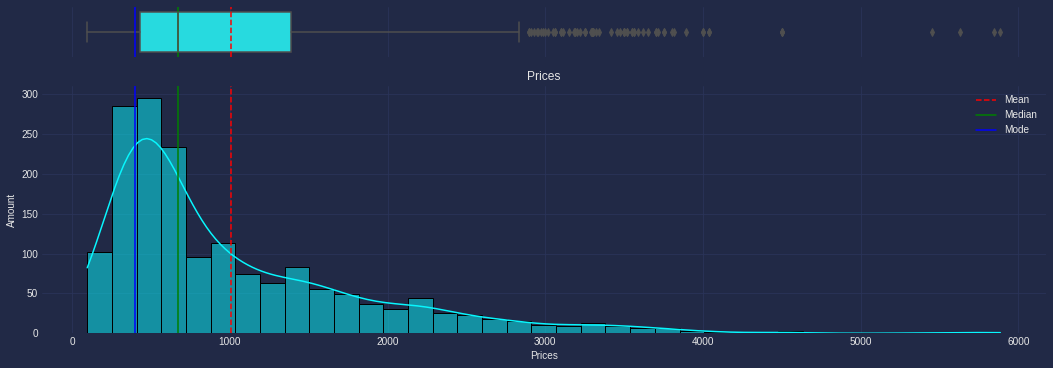

In [ ]:
hist_and_boxplot('Цены', 'Prices', 'Amount', 'Prices')

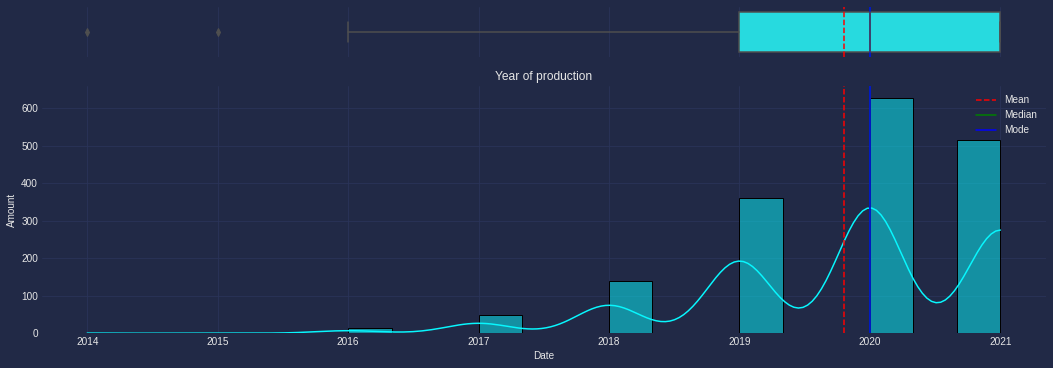

In [ ]:
hist_and_boxplot('Дата выхода на рынок', 'Date', 'Amount', 'Year of production')

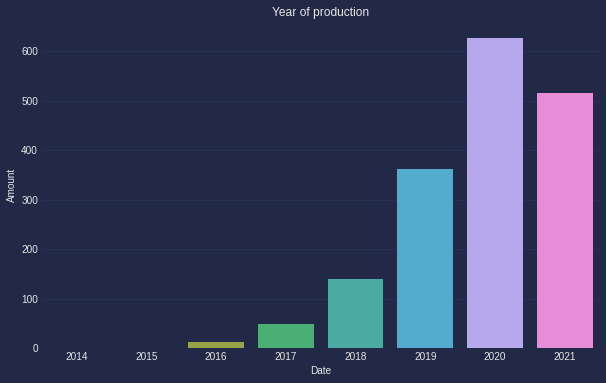

In [ ]:
hist('Дата выхода на рынок', "Date", 'Amount', "Year of production", (10, 6))

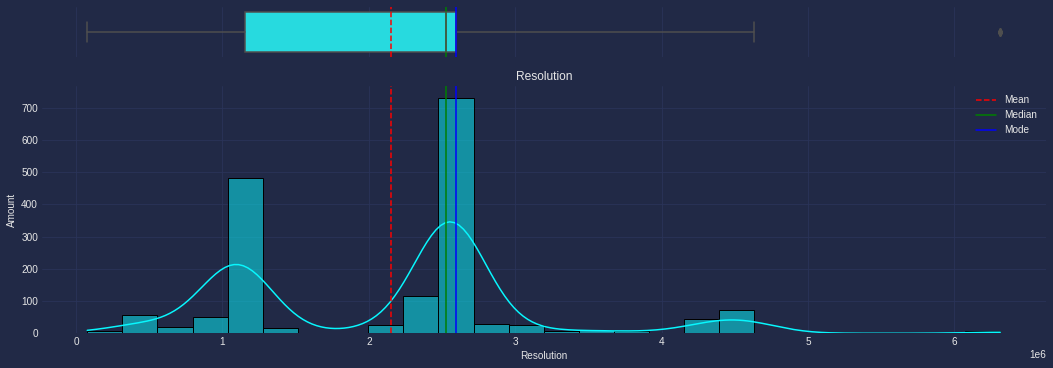

In [ ]:
hist_and_boxplot('Разрешение экрана', 'Resolution', 'Amount', 'Resolution')

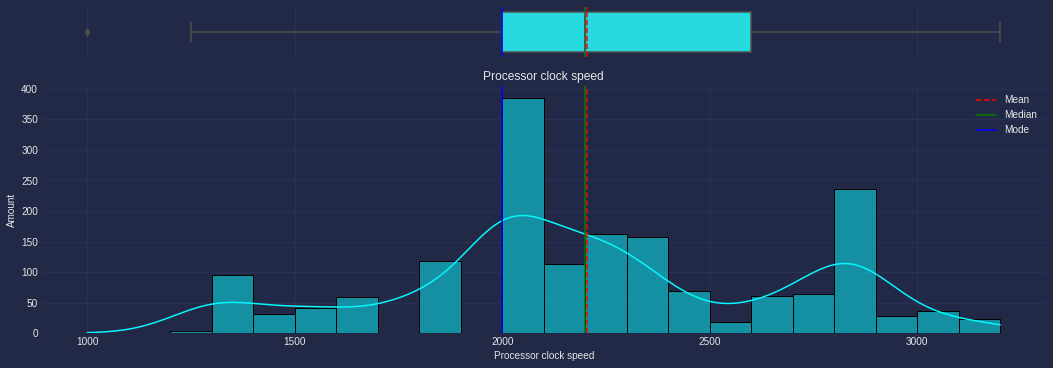

In [ ]:
hist_and_boxplot('Тактовая частота процессора', 'Processor clock speed', 'Amount', 'Processor clock speed')

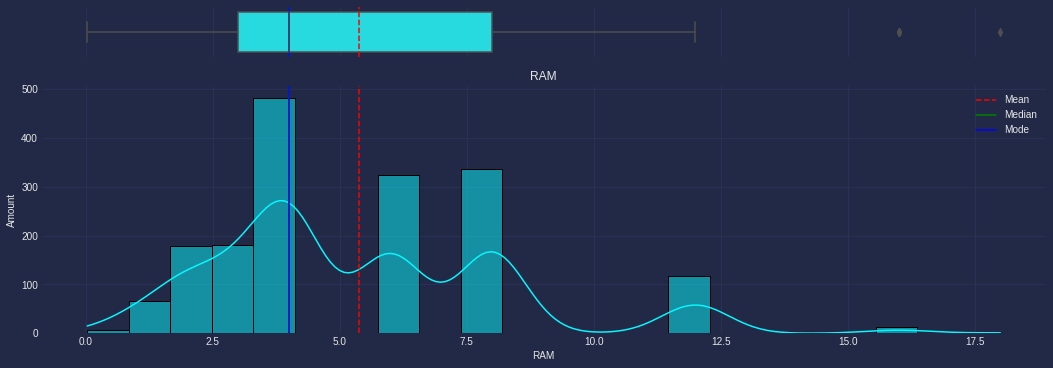

In [ ]:
hist_and_boxplot('Оперативная память', 'RAM', 'Amount', 'RAM')

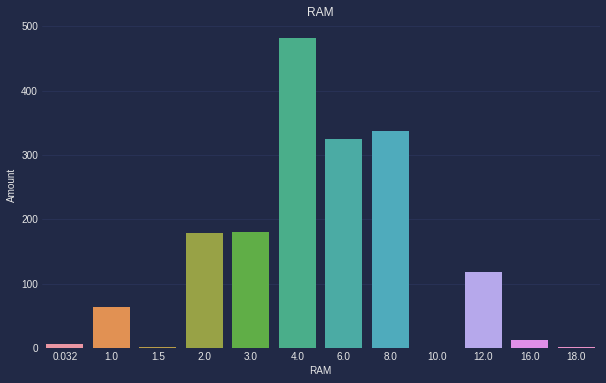

In [ ]:
hist('Оперативная память', "RAM", 'Amount', "RAM", (10, 6))

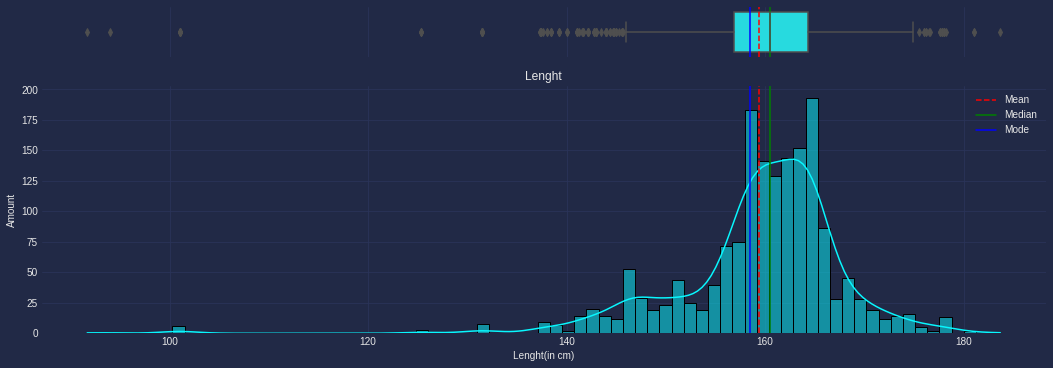

In [ ]:
hist_and_boxplot('Длина', 'Lenght(in cm)', 'Amount', 'Lenght')

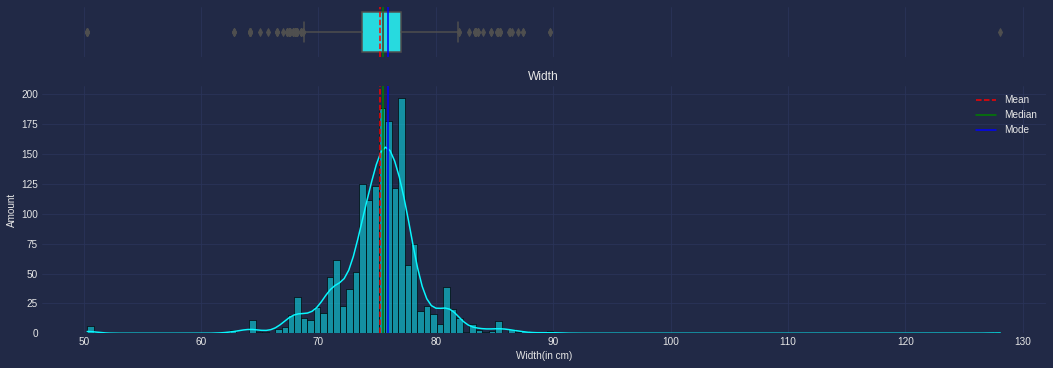

In [ ]:
hist_and_boxplot('Ширина', 'Width(in cm)', 'Amount', 'Width')

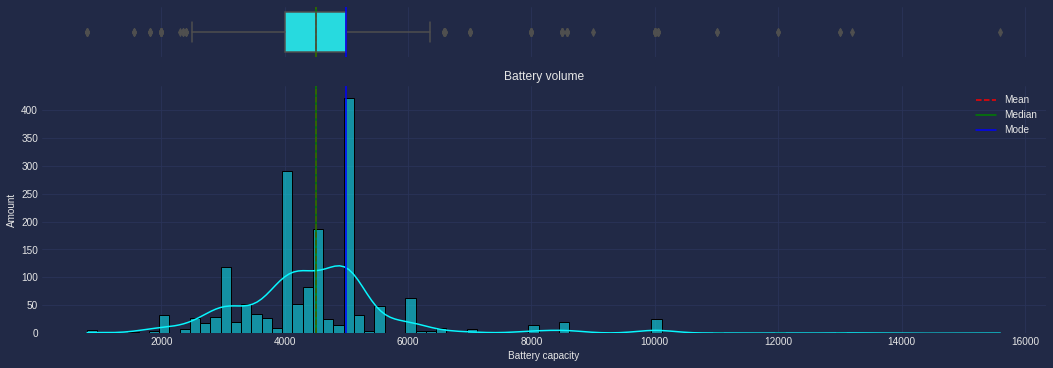

In [ ]:
hist_and_boxplot('Емкость аккумулятора', 'Battery capacity', 'Amount', 'Battery volume')

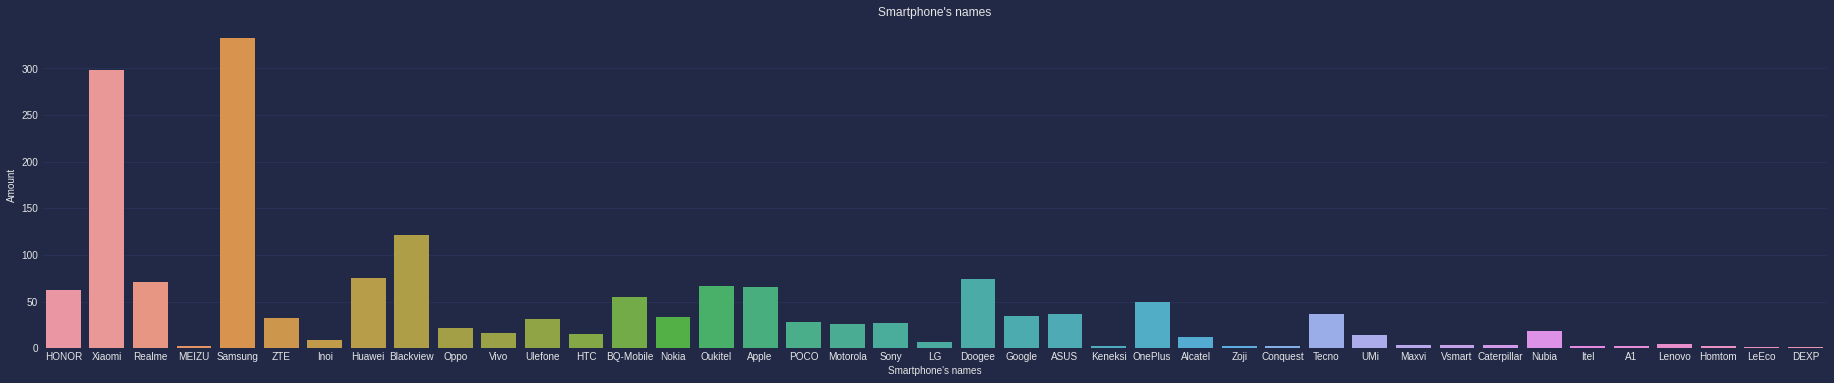

In [ ]:
hist('Название', "Smartphone's names", 'Amount', "Smartphone's names")

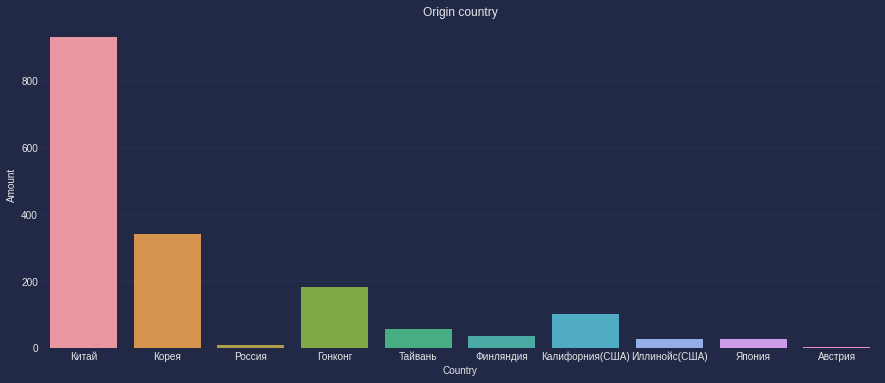

In [ ]:
hist('Производитель', "Country", 'Amount', "Origin country", (15,6))

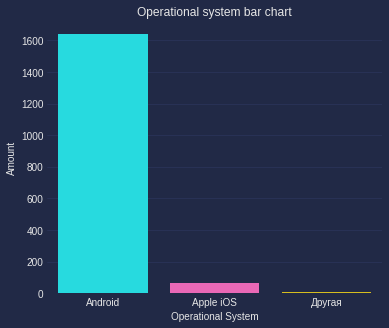

In [ ]:
hist('Операционная система', "Operational System", 'Amount', "Operational system bar chart", (6,5))

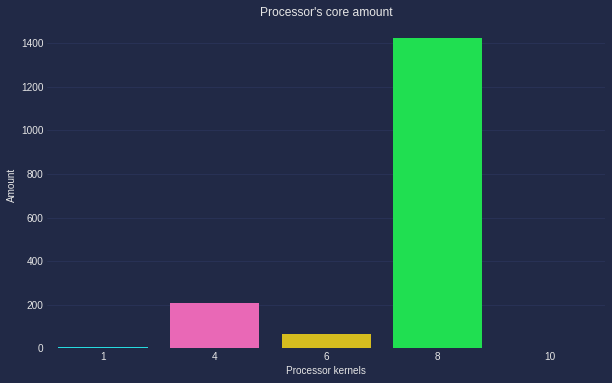

In [ ]:
hist('Количество ядер', "Processor kernels", 'Amount', "Processor's core amount", (10, 6))

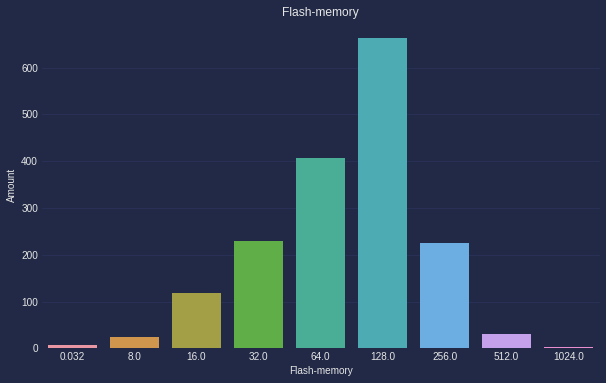

In [ ]:
hist('Флэш-память', "Flash-memory", 'Amount', "Flash-memory", (10, 6))

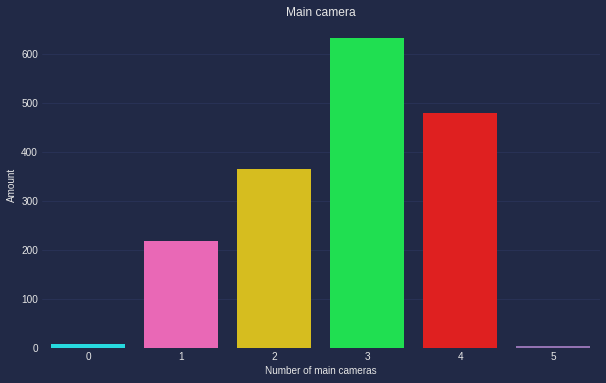

In [ ]:
hist('Количество основных камер', "Number of main cameras", 'Amount', "Main camera", (10, 6))

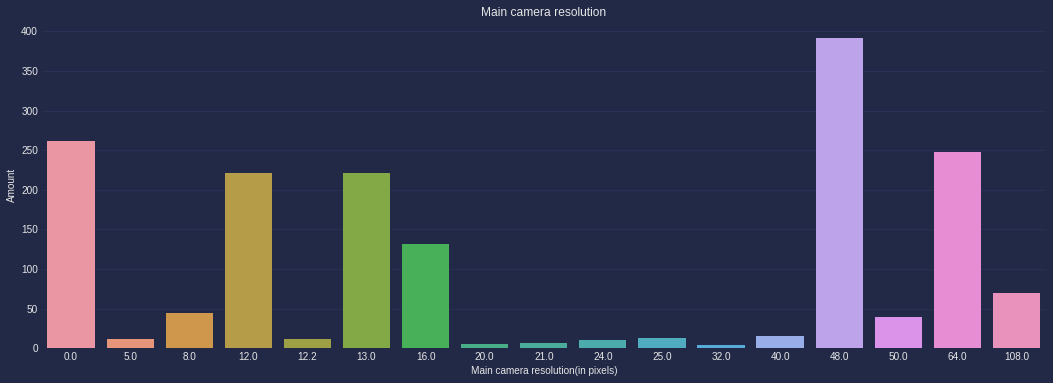

In [ ]:
hist('Встроенная камера', "Main camera resolution(in pixels)", 'Amount', "Main camera resolution", (18, 6))

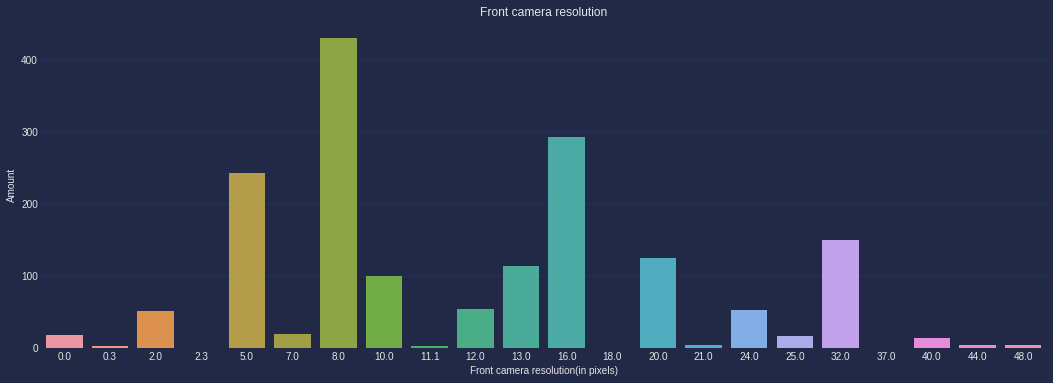

In [ ]:
hist('Фронтальная камера', "Front camera resolution(in pixels)", 'Amount', "Front camera resolution", (18, 6))

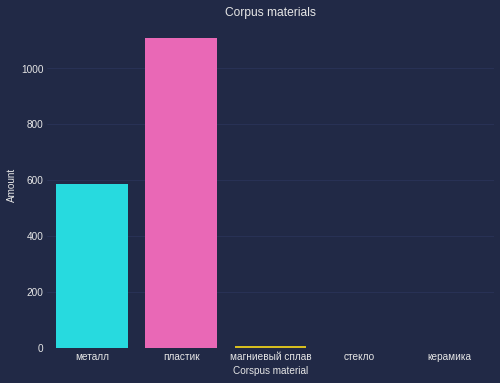

In [ ]:
hist('Материал корпуса', "Corspus material", 'Amount', "Corpus materials", (8, 6))

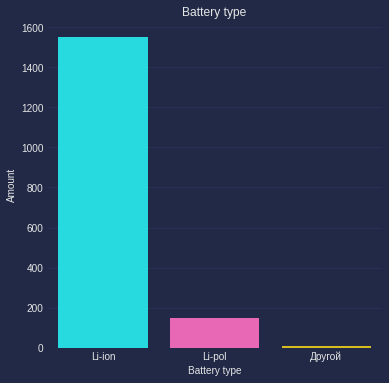

In [ ]:
hist('Тип аккумулятора', "Battery type", 'Amount', "Battery type", (6, 6))

In [ ]:
data['Wi-Fi'].value_counts()

1    1676
0      33
Name: Wi-Fi, dtype: int64

In [ ]:
data['Bluetooth'].value_counts()

1    1695
0      14
Name: Bluetooth, dtype: int64

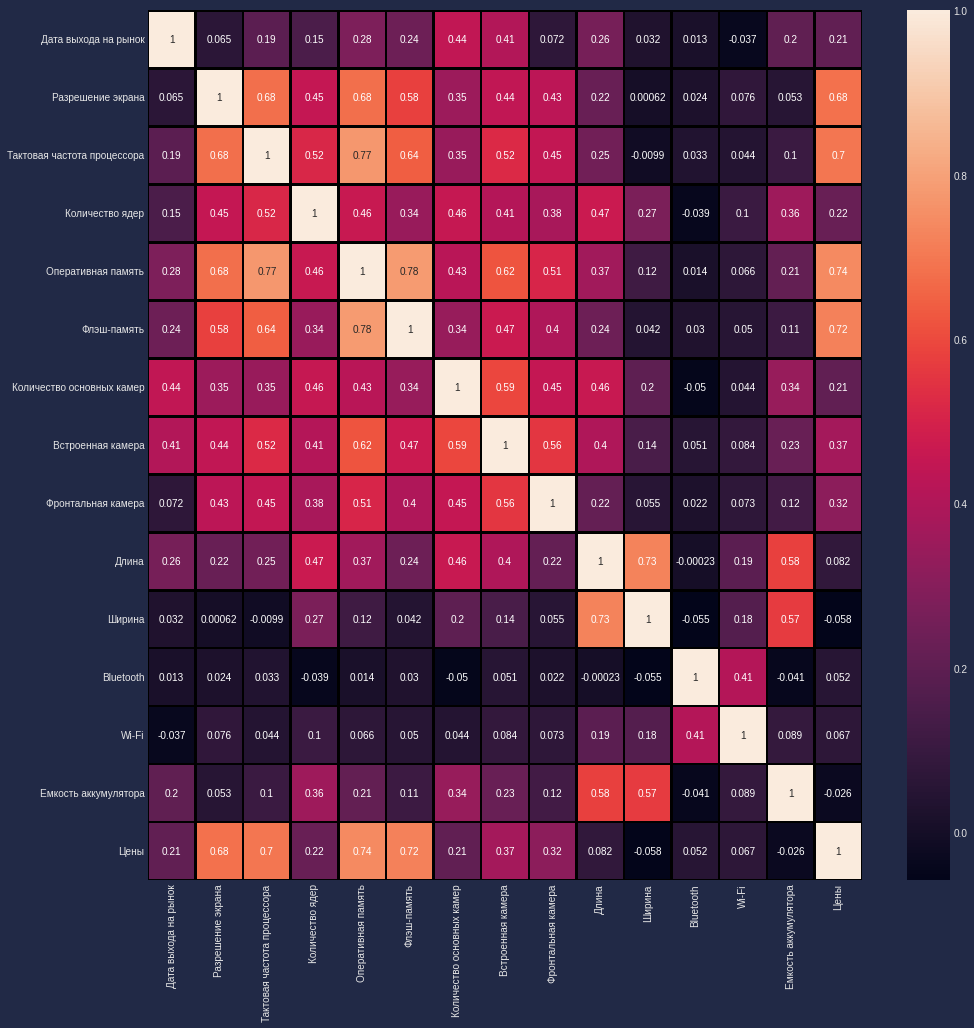

In [ ]:
corr = data.corr()
plt.figure(figsize = (16, 16))
sns.heatmap(corr, annot = True, linewidth = 1.5, linecolor = 'black', fmt='.2g')

Here we can see, that "operational system", "flash-memory", "Processor clock speed" and "Screen resolution" are most influational according to correlation coefficient. But they are also correlated with one another which reffers to multicorrelation.

From now we already can say about some of our hypotheses:
* Screen resolution width and length are dependent on each other;
* Bluetooth- and Wifi-support are often shipped together, because almost all of smartphones have both wifi- and Bluetooth availability;
* Androids are cheaper than IOS in general, but the most expensive smartphones are Androids;
* Battery capacity depends on the size of the smartphone;

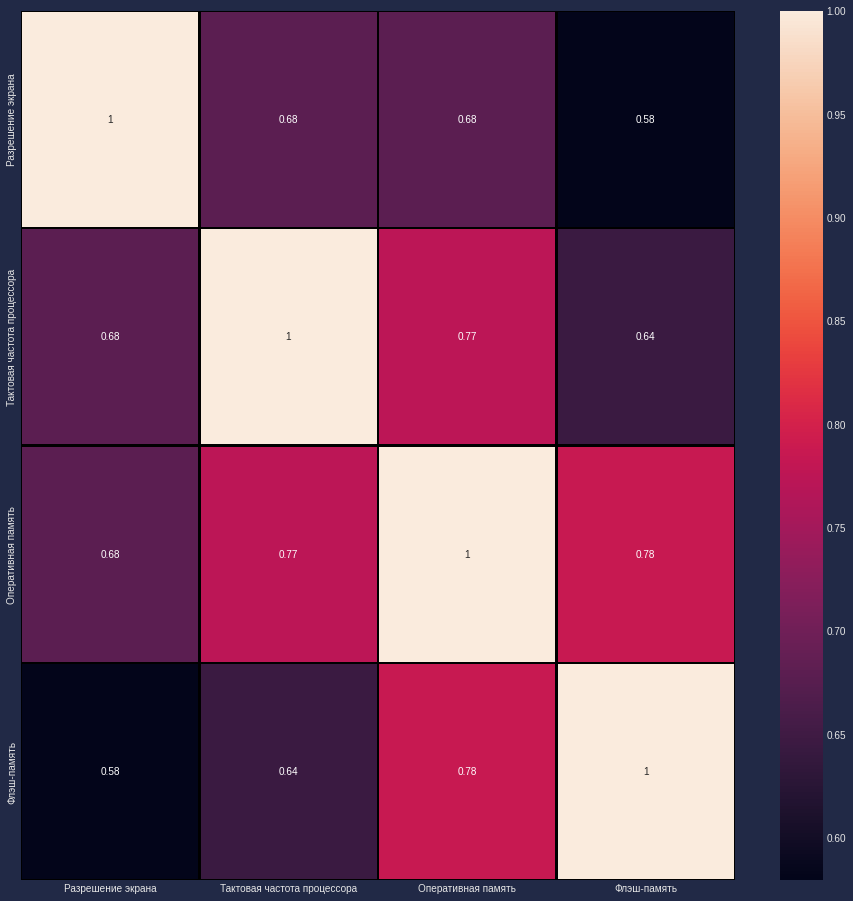

In [ ]:
df = data[['Разрешение экрана', 'Тактовая частота процессора', 'Оперативная память', 'Флэш-память']]

corr = df.corr()
plt.figure(figsize = (16, 16))
sns.heatmap(corr, annot = True, linewidth = 1.5, linecolor = 'black', fmt='.2g')

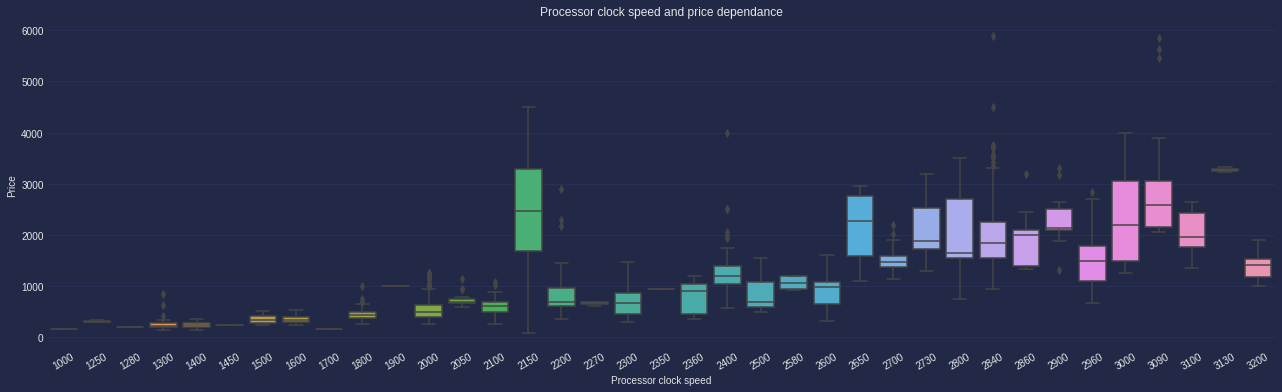

In [ ]:
plot_two_variables(
    data['Тактовая частота процессора'], 
    data['Цены'], 
    'Processor clock speed', 
    'Price', 
    'Processor clock speed and price dependance',
    (22,6))

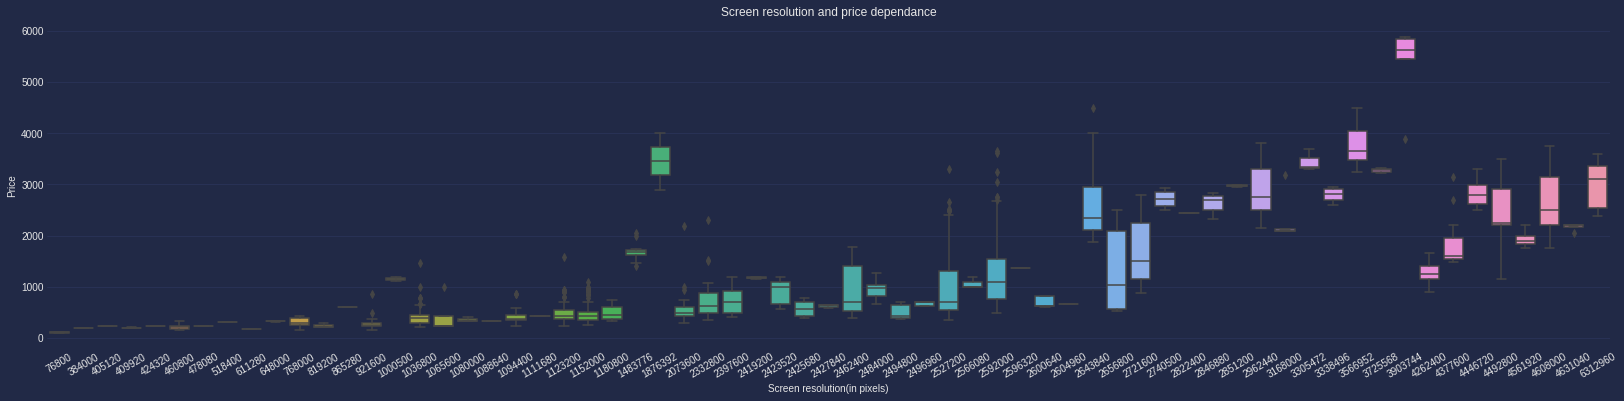

In [ ]:
plot_two_variables(
    data['Разрешение экрана'], 
    data['Цены'], 
    'Screen resolution(in pixels)', 
    'Price', 
    'Screen resolution and price dependance',
    (28,6))

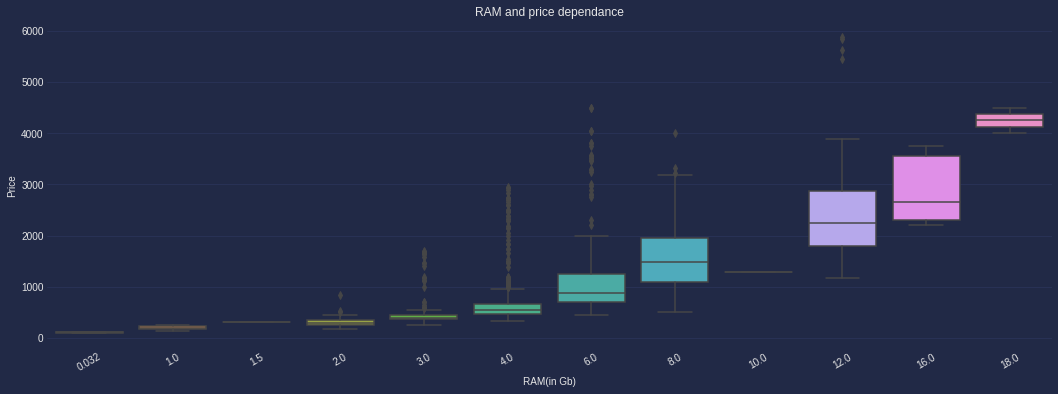

In [ ]:
plot_two_variables(
    data['Оперативная память'], 
    data['Цены'], 
    'RAM(in Gb)', 
    'Price', 
    'RAM and price dependance',
    (18,6))

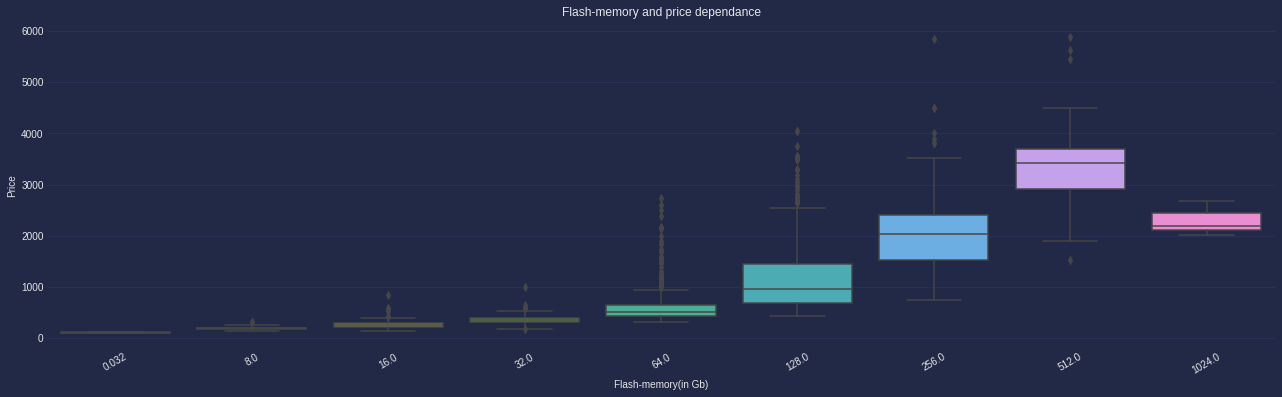

In [ ]:
plot_two_variables(
    data['Флэш-память'], 
    data['Цены'], 
    'Flash-memory(in Gb)', 
    'Price', 
    'Flash-memory and price dependance',
    (22,6))

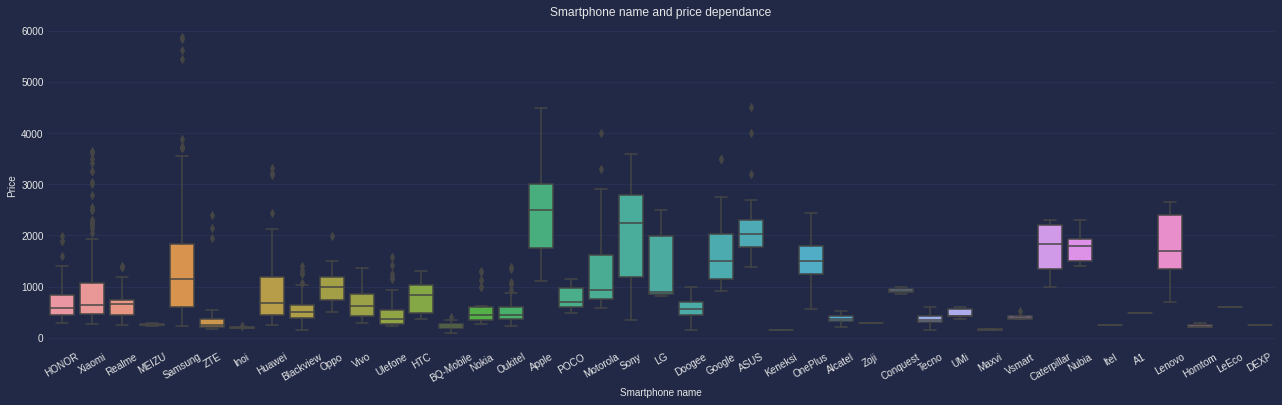

In [ ]:
plot_two_variables(
    data['Название'], 
    data['Цены'], 
    'Smartphone name', 
    'Price', 
    'Smartphone name and price dependance',
    (22,6))

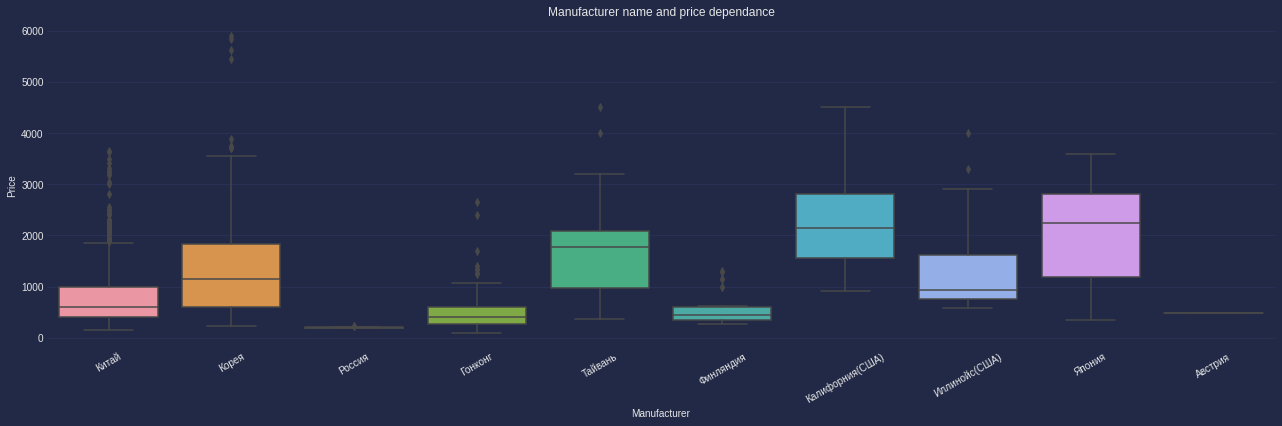

In [ ]:
plot_two_variables(
    data['Производитель'], 
    data['Цены'], 
    'Manufacturer', 
    'Price', 
    'Manufacturer name and price dependance',
    (22,6))

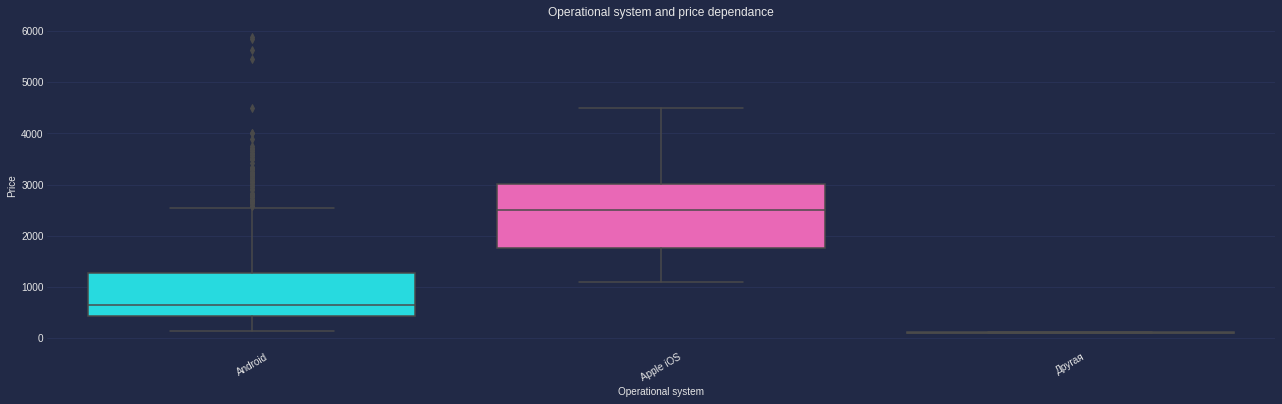

In [ ]:
plot_two_variables(
    data['Операционная система'], 
    data['Цены'], 
    'Operational system', 
    'Price', 
    'Operational system and price dependance',
    (22,6))

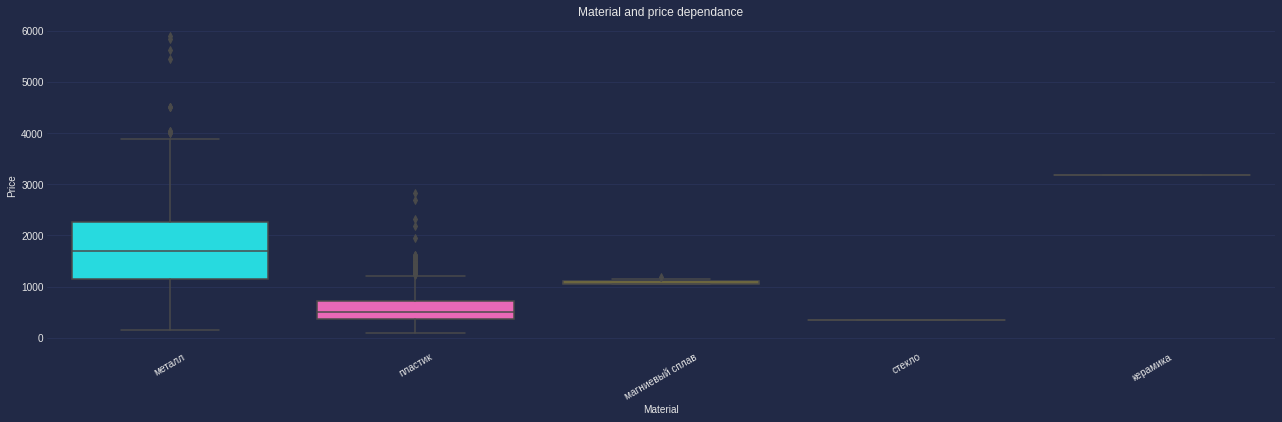

In [ ]:
plot_two_variables(
    data['Материал корпуса'], 
    data['Цены'], 
    'Material', 
    'Price', 
    'Material and price dependance',
    (22,6))

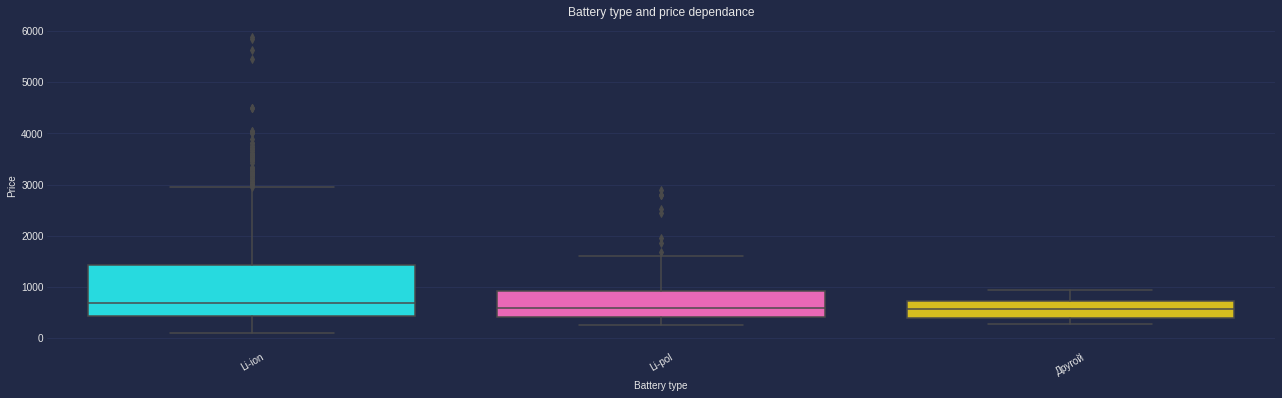

In [ ]:
plot_two_variables(
    data['Тип аккумулятора'], 
    data['Цены'], 
    'Battery type', 
    'Price', 
    'Battery type and price dependance',
    (22,6))

# **V. Feature engineering**

Here we transform the categorial data so that ML-algorithms can process it.


## **Feature Transformation**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1709 entries, 0 to 1768
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Название                     1709 non-null   object 
 1   Производитель                1709 non-null   object 
 2   Дата выхода на рынок         1709 non-null   int64  
 3   Операционная система         1709 non-null   object 
 4   Разрешение экрана            1709 non-null   int64  
 5   Тактовая частота процессора  1709 non-null   int64  
 6   Количество ядер              1709 non-null   int64  
 7   Оперативная память           1709 non-null   float64
 8   Флэш-память                  1709 non-null   float64
 9   Количество основных камер    1709 non-null   int64  
 10  Встроенная камера            1709 non-null   float64
 11  Фронтальная камера           1709 non-null   float64
 12  Материал корпуса             1709 non-null   object 
 13  Длина             

In [ ]:
data_transformation = data.iloc[:, 1:len(data.columns)-1].copy()

In [ ]:
data_transformation

,Производитель,Дата выхода на рынок,Операционная система,Разрешение экрана,Тактовая частота процессора,Количество ядер,Оперативная память,Флэш-память,Количество основных камер,Встроенная камера,Фронтальная камера,Материал корпуса,Длина,Ширина,Bluetooth,Wi-Fi,Тип аккумулятора,Емкость аккумулятора
0,Китай,2018,Android,2527200,2200,8,4.0,128.0,2,20.0,16.0,металл,160.40,76.60,1,1,Li-ion,3750
1,Китай,2020,Android,2592000,2300,8,6.0,128.0,4,48.0,16.0,пластик,165.80,76.70,1,1,Li-ion,5020
2,Китай,2021,Android,2592000,2300,8,6.0,128.0,3,64.0,16.0,пластик,160.53,75.73,1,1,Li-ion,4250
3,Китай,2021,Android,1152000,1800,8,4.0,64.0,3,13.0,5.0,пластик,164.50,76.00,1,1,Li-ion,5000
4,Китай,2019,Android,1094400,1800,8,3.0,32.0,2,12.0,8.0,пластик,158.70,75.60,1,1,Li-pol,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,Китай,2021,Android,2592000,2840,8,12.0,128.0,3,64.0,8.0,металл,169.86,77.20,1,1,Li-ion,5050
1765,Китай,2021,Android,2592000,2050,8,8.0,256.0,4,48.0,16.0,пластик,183.70,85.30,1,1,Li-ion,13200
1766,Гонконг,2019,Android,2527200,2100,8,6.0,128.0,3,48.0,16.0,пластик,168.50,81.00,1,1,Li-ion,6580
1767,Китай,2020,Android,2592000,2840,8,12.0,256.0,3,48.0,16.0,металл,160.20,72.90,1,1,Li-ion,4300


In [ ]:
data_transformed = pd.get_dummies(data_transformation.iloc[:, 0:len(data_transformation.columns)])
data_transformed['Цены'] = data['Цены']

In [ ]:
data_transformed.iloc[1, :]

Дата выхода на рынок                   2020.0
Разрешение экрана                   2592000.0
Тактовая частота процессора            2300.0
Количество ядер                           8.0
Оперативная память                        6.0
Флэш-память                             128.0
Количество основных камер                 4.0
Встроенная камера                        48.0
Фронтальная камера                       16.0
Длина                                   165.8
Ширина                                   76.7
Bluetooth                                 1.0
Wi-Fi                                     1.0
Емкость аккумулятора                   5020.0
Производитель_Австрия                     0.0
Производитель_Гонконг                     0.0
Производитель_Иллинойс(США)               0.0
Производитель_Калифорния(США)             0.0
Производитель_Китай                       1.0
Производитель_Корея                       0.0
Производитель_Россия                      0.0
Производитель_Тайвань             

## **Feature Selection**

In [ ]:
X = data_transformed.iloc[:, :len(data_transformed.columns)-1]
y = np.log10(data_transformed['Цены'])

feature_names = data_transformed.columns[0:len(data_transformed.columns)-1]

### **t- and F-statistics**

In [ ]:
scaler = StandardScaler()

X_const = X.copy()
# X_const_scaled = scaler.fit_transform(X_const)
# X_const = sm.add_constant(X_const)

model = sm.OLS(y, X_const.assign(const = 1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цены   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     703.4
Date:                Sun, 12 Jun 2022   Prob (F-statistic):               0.00
Time:                        06:40:48   Log-Likelihood:                 1741.8
No. Observations:                1709   AIC:                            -3420.
Df Residuals:                    1677   BIC:                            -3245.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Дата вых

### **Hat-value and Cook's distance**

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:695: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


Text(0, 0.5, 'Стандартные остатки')

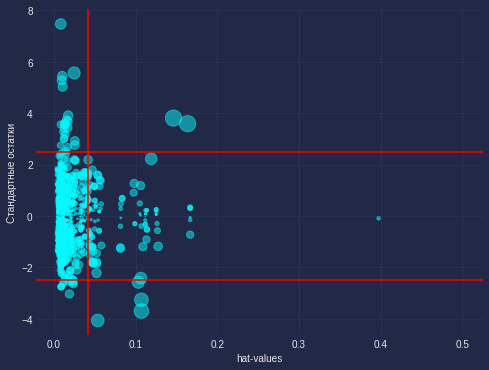

In [ ]:
influence = OLSInfluence(results)
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(-2.5, linestyle = '-', color = 'red')
ax.axhline(2.5, linestyle = '-', color = 'red')
ax.axvline(0.042, linestyle = '-', color = 'red')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
s = 1000 * np.sqrt(influence.cooks_distance[0]),
alpha = 0.5)
ax.set_xlabel('hat-values')
ax.set_ylabel('Стандартные остатки')


In [ ]:
hat = 0.042
cook = 0.002

In [ ]:
sresiduals = influence.resid_studentized_internal
sresiduals

0       0.372946
1      -0.591748
2       0.434665
3      -0.396923
4       0.477758
          ...   
1764    0.161860
1765    0.077484
1766    1.666214
1767   -0.371354
1768   -0.276222
Length: 1709, dtype: float64

In [ ]:
hats = pd.Series(influence.hat_matrix_diag)
hats.index = sresiduals.index
hats
# plt.plot(hats)

0       0.007787
1       0.002945
2       0.004174
3       0.004656
4       0.009010
          ...   
1764    0.012409
1765    0.030505
1766    0.010552
1767    0.007723
1768    0.007696
Length: 1709, dtype: float64

In [ ]:
cooks_distance = np.sqrt(influence.cooks_distance[0])
cooks_distance
# plt.plot(cooks_distance)

0       0.005506
1       0.005360
2       0.004690
3       0.004525
4       0.007592
          ...   
1764    0.003024
1765    0.002291
1766    0.028678
1767    0.005460
1768    0.004054
Length: 1709, dtype: float64

### **Forward and backward selection**

In [ ]:
linear_regression = LinearRegression(n_jobs=-1)

forward_selection = SequentialFeatureSelector(linear_regression, n_features_to_select=14, direction="forward")
backward_selection = SequentialFeatureSelector(linear_regression, n_features_to_select=14, direction="backward")

forward_selection.fit(X, y)
forward_selection_feature_names = pd.Series(feature_names[forward_selection.get_support()])
print(
    "Features selected by forward sequential selection: \n"
    f"{forward_selection_feature_names}"
)

backward_selection.fit(X, y)
backward_selection_feature_names = pd.Series(feature_names[backward_selection.get_support()])
print(
    "\n Features selected by forward sequential selection: \n"
    f"{backward_selection_feature_names}"
)

Features selected by forward sequential selection: 
0                  Разрешение экрана
1        Тактовая частота процессора
2                 Оперативная память
3                        Флэш-память
4                  Встроенная камера
5               Емкость аккумулятора
6              Производитель_Гонконг
7        Производитель_Иллинойс(США)
8      Производитель_Калифорния(США)
9                Производитель_Китай
10              Производитель_Япония
11      Операционная система_Android
12    Операционная система_Apple iOS
13          Материал корпуса_пластик
dtype: object

 Features selected by forward sequential selection: 
0                  Разрешение экрана
1        Тактовая частота процессора
2                 Оперативная память
3                        Флэш-память
4                  Встроенная камера
5               Емкость аккумулятора
6        Производитель_Иллинойс(США)
7      Производитель_Калифорния(США)
8                Производитель_Корея
9              Производитель_

### **Permutation importance**

In [ ]:
model = RandomForestRegressor(n_estimators=300, random_state=0).fit(X, y)
perm = PermutationImportance(model ,random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.2509 ± 0.0209,Оперативная память
0.1613 ± 0.0060,Тактовая частота процессора
0.1178 ± 0.0041,Флэш-память
0.0671 ± 0.0036,Разрешение экрана
0.0587 ± 0.0060,Производитель_Калифорния(США)
0.0158 ± 0.0019,Встроенная камера
0.0110 ± 0.0010,Длина
0.0105 ± 0.0005,Ширина
0.0102 ± 0.0019,Емкость аккумулятора
0.0087 ± 0.0010,Материал корпуса_пластик


### **RandomForest's feature importance**

In [ ]:
model = RandomForestRegressor(n_estimators=340)
model.fit(X, y)

importances = model.feature_importances_
random_forest_importances = pd.DataFrame({"Features" : pd.DataFrame(X).columns, "Importances" : importances}).sort_values('Importances', ascending = False)

print(random_forest_importances)

                            Features  Importances
4                 Оперативная память     0.299988
5                        Флэш-память     0.285075
2        Тактовая частота процессора     0.132069
17     Производитель_Калифорния(США)     0.056343
1                  Разрешение экрана     0.044016
30          Материал корпуса_пластик     0.043195
29           Материал корпуса_металл     0.040252
9                              Длина     0.012235
10                            Ширина     0.011691
13              Емкость аккумулятора     0.011511
7                  Встроенная камера     0.010495
8                 Фронтальная камера     0.009470
25    Операционная система_Apple iOS     0.009215
24      Операционная система_Android     0.007533
0               Дата выхода на рынок     0.007219
18               Производитель_Китай     0.005103
6          Количество основных камер     0.004836
3                    Количество ядер     0.003671
16       Производитель_Иллинойс(США)     0.002564


### **Correlation matrix**

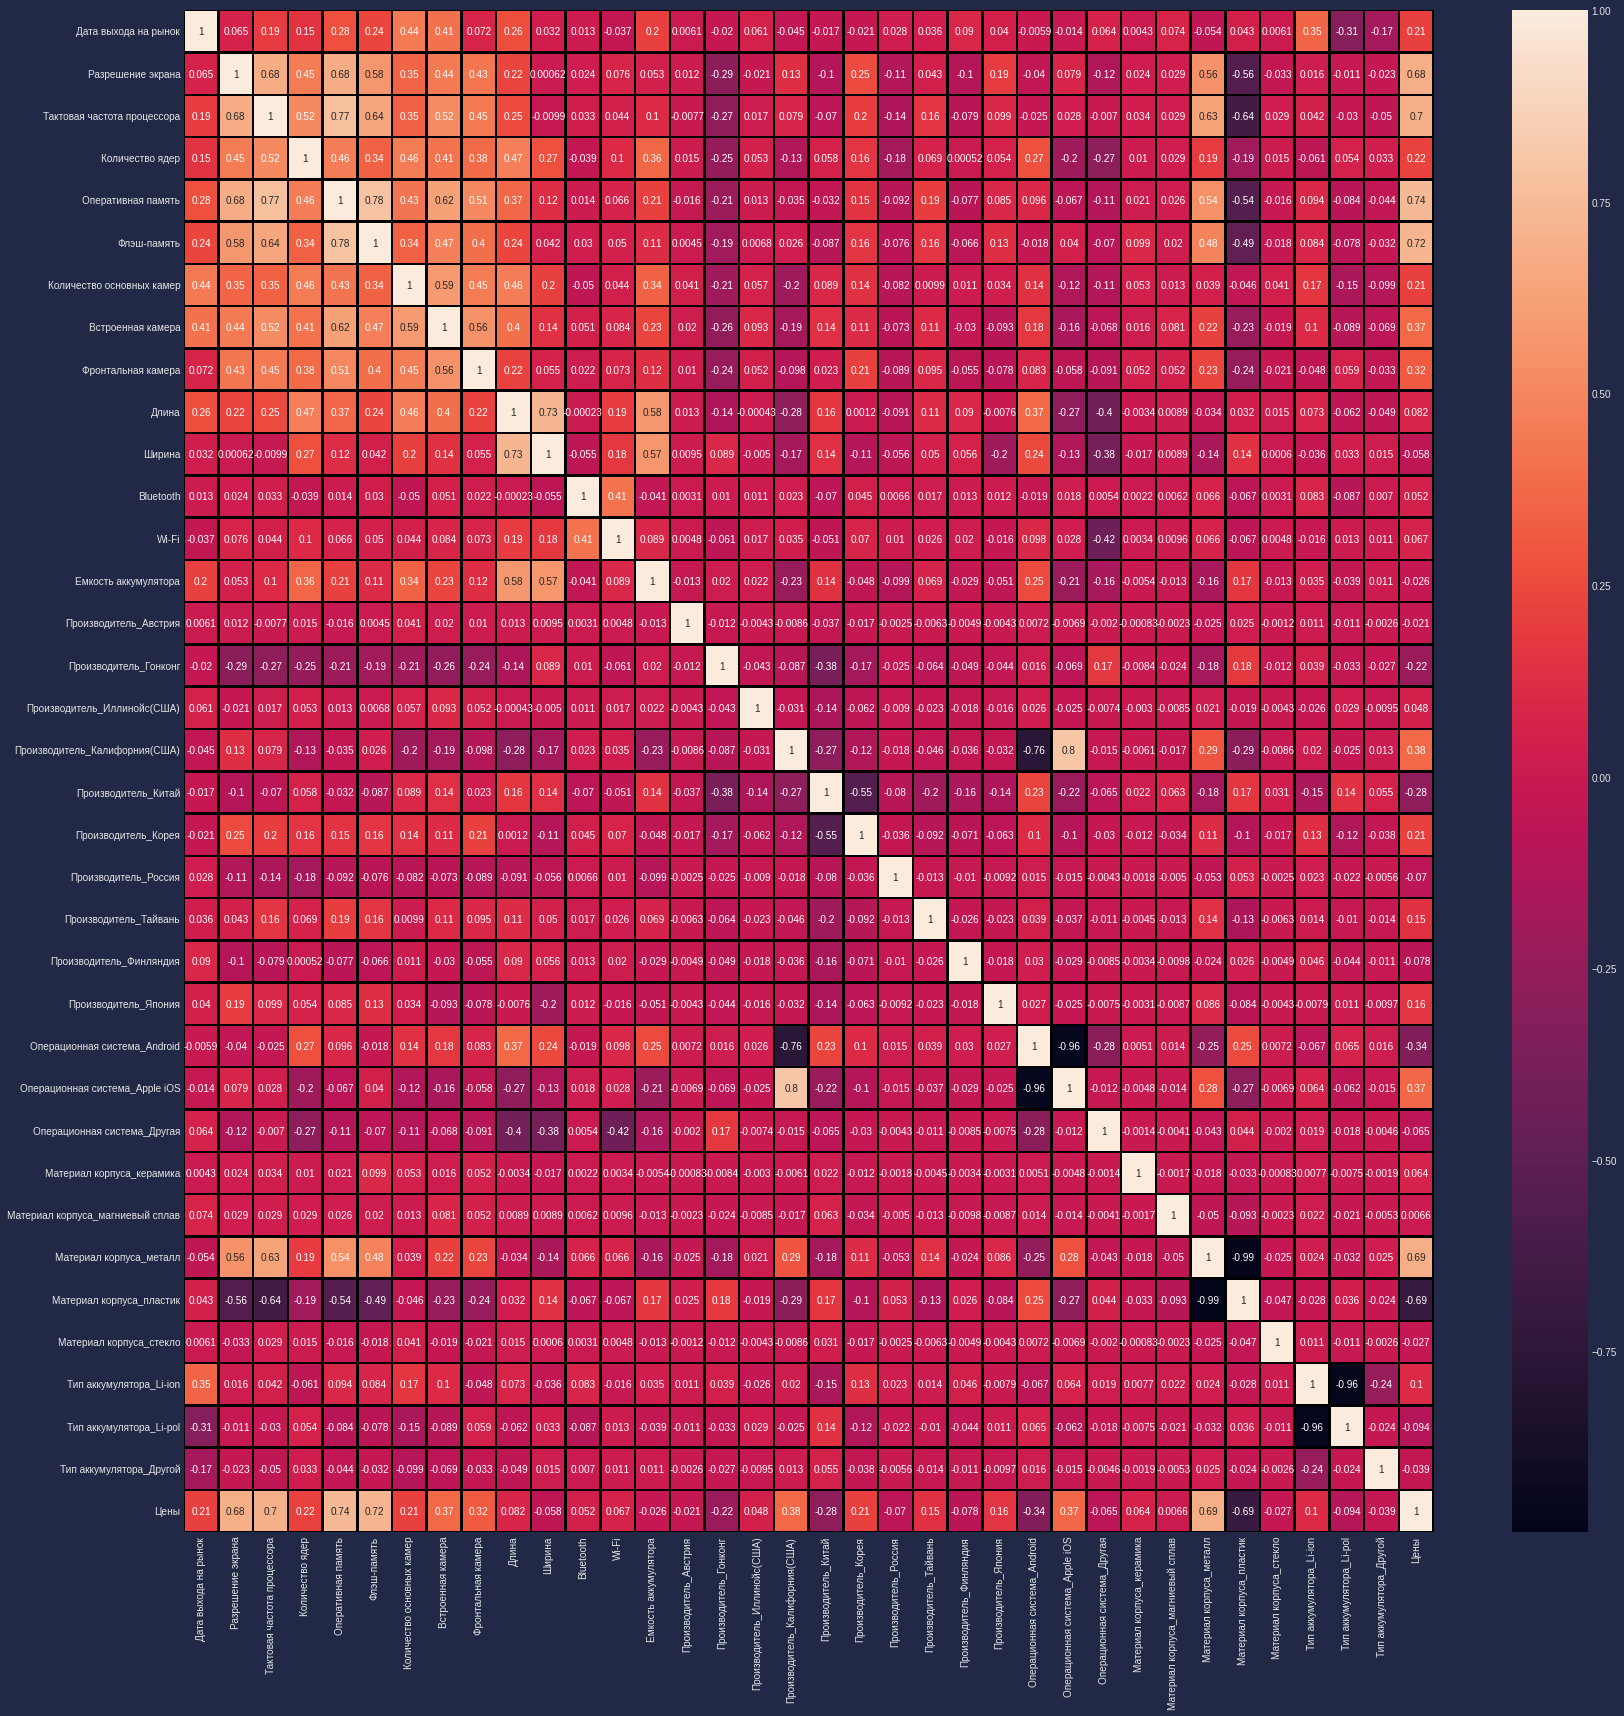

In [ ]:
corr = data_transformed.corr()
plt.figure(figsize = (28, 28))
sns.heatmap(corr, annot = True, linewidth = 1.5, linecolor = 'black', fmt='.2g')

## **Conclusion**

These are the features that are important for price prediction

In [ ]:
# features = ['Тактовая частота процессора', 'Материал корпуса_металл', 'Разрешение экрана', 
#             'Оперативная память', 'Операционная система_Apple iOS', 'Флэш-память',
#             'Дата выхода на рынок', 'Емкость аккумулятора', 'Производитель_Калифорния(США)',
#             'Количество ядер', 'Встроенная камера', 'Фронтальная камера', 
#             'Производитель_Корея', 'Цены']

features = ['Тактовая частота процессора', 'Материал корпуса_металл', 'Разрешение экрана', 
            'Оперативная память', 'Операционная система_Apple iOS', 'Флэш-память',
            'Дата выхода на рынок', 'Производитель_Калифорния(США)', 'Встроенная камера',
            'Фронтальная камера', 'Производитель_Китай', 'Емкость аккумулятора',
            'Производитель_Корея', 'Цены']

In [ ]:
data_prepared = data_transformed[features].copy()

In [ ]:
data_prepared['Residual Errors'] = sresiduals
data_prepared['Hats'] = hats

In [ ]:
data_prepared.dropna()

,Тактовая частота процессора,Материал корпуса_металл,Разрешение экрана,Оперативная память,Операционная система_Apple iOS,Флэш-память,Дата выхода на рынок,Производитель_Калифорния(США),Встроенная камера,Фронтальная камера,Производитель_Китай,Емкость аккумулятора,Производитель_Корея,Цены,Residual Errors,Hats
0,2200,1,2527200,4.0,0,128.0,2018,0,20.0,16.0,1,3750,0,699.0,0.372946,0.007787
1,2300,0,2592000,6.0,0,128.0,2020,0,48.0,16.0,1,5020,0,670.0,-0.591748,0.002945
2,2300,0,2592000,6.0,0,128.0,2021,0,64.0,16.0,1,4250,0,870.0,0.434665,0.004174
3,1800,0,1152000,4.0,0,64.0,2021,0,13.0,5.0,1,5000,0,377.5,-0.396923,0.004656
4,1800,0,1094400,3.0,0,32.0,2019,0,12.0,8.0,1,4000,0,399.0,0.477758,0.009010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,2840,1,2592000,12.0,0,128.0,2021,0,64.0,8.0,1,5050,0,1900.0,0.161860,0.012409
1765,2050,0,2592000,8.0,0,256.0,2021,0,48.0,16.0,1,13200,0,1145.0,0.077484,0.030505
1766,2100,0,2527200,6.0,0,128.0,2019,0,48.0,16.0,0,6580,0,1029.0,1.666214,0.010552
1767,2840,1,2592000,12.0,0,256.0,2020,0,48.0,16.0,1,4300,0,1749.0,-0.371354,0.007723


In [ ]:
data_prepared = data_prepared[(data_prepared['Hats'] <= hat) & (data_prepared['Residual Errors'] <= 2.5) & (data_prepared['Residual Errors'] >= -2.5)]

In [ ]:
data_prepared

,Тактовая частота процессора,Материал корпуса_металл,Разрешение экрана,Оперативная память,Операционная система_Apple iOS,Флэш-память,Дата выхода на рынок,Производитель_Калифорния(США),Встроенная камера,Фронтальная камера,Производитель_Китай,Емкость аккумулятора,Производитель_Корея,Цены,Residual Errors,Hats
0,2200,1,2527200,4.0,0,128.0,2018,0,20.0,16.0,1,3750,0,699.0,0.372946,0.007787
1,2300,0,2592000,6.0,0,128.0,2020,0,48.0,16.0,1,5020,0,670.0,-0.591748,0.002945
2,2300,0,2592000,6.0,0,128.0,2021,0,64.0,16.0,1,4250,0,870.0,0.434665,0.004174
3,1800,0,1152000,4.0,0,64.0,2021,0,13.0,5.0,1,5000,0,377.5,-0.396923,0.004656
4,1800,0,1094400,3.0,0,32.0,2019,0,12.0,8.0,1,4000,0,399.0,0.477758,0.009010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,2840,1,2592000,12.0,0,128.0,2021,0,64.0,8.0,1,5050,0,1900.0,0.161860,0.012409
1765,2050,0,2592000,8.0,0,256.0,2021,0,48.0,16.0,1,13200,0,1145.0,0.077484,0.030505
1766,2100,0,2527200,6.0,0,128.0,2019,0,48.0,16.0,0,6580,0,1029.0,1.666214,0.010552
1767,2840,1,2592000,12.0,0,256.0,2020,0,48.0,16.0,1,4300,0,1749.0,-0.371354,0.007723


In [ ]:
data_prepared_const = data_prepared.iloc[:, 0:len(data_prepared.columns)-3].copy()
Y = np.log10(data_prepared['Цены'].copy())

# data_prepared_const = sm.add_constant(data_prepared)
model = sm.OLS(Y, data_prepared_const.assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цены   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1906.
Date:                Sun, 12 Jun 2022   Prob (F-statistic):               0.00
Time:                        06:41:38   Log-Likelihood:                 1799.3
No. Observations:                1555   AIC:                            -3571.
Df Residuals:                    1541   BIC:                            -3496.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Тактовая час

# **VI. Short-List Promising Models**

First let's build some models without fine tuning to see how they perform on the training set

In [ ]:
# data_prepared = data_prepared.loc[(data_prepared['Цены'] <= 2000)]

In [ ]:
# data_prepared['Цены'] = np.log10(data_prepared['Цены']) # np.log(data_prepared['Цены'])

In [ ]:
def plot_learning_curve(model, X_train, y_train, scoring):
    scoring = scoring
    
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, scoring = scoring, train_sizes = [0.1, 0.25, 0.5, 0.75, 1])

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)    
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'train-set')
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="validation-set")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.2)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='g', alpha=0.2)
    
    plt.xlabel("Number of samples")
    plt.ylabel(scoring)
    plt.legend(loc="lower right")
    plt.grid(True)

In [ ]:
data_prepared

,Тактовая частота процессора,Материал корпуса_металл,Разрешение экрана,Оперативная память,Операционная система_Apple iOS,Флэш-память,Дата выхода на рынок,Производитель_Калифорния(США),Встроенная камера,Фронтальная камера,Производитель_Китай,Емкость аккумулятора,Производитель_Корея,Цены,Residual Errors,Hats
0,2200,1,2527200,4.0,0,128.0,2018,0,20.0,16.0,1,3750,0,699.0,0.372946,0.007787
1,2300,0,2592000,6.0,0,128.0,2020,0,48.0,16.0,1,5020,0,670.0,-0.591748,0.002945
2,2300,0,2592000,6.0,0,128.0,2021,0,64.0,16.0,1,4250,0,870.0,0.434665,0.004174
3,1800,0,1152000,4.0,0,64.0,2021,0,13.0,5.0,1,5000,0,377.5,-0.396923,0.004656
4,1800,0,1094400,3.0,0,32.0,2019,0,12.0,8.0,1,4000,0,399.0,0.477758,0.009010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,2840,1,2592000,12.0,0,128.0,2021,0,64.0,8.0,1,5050,0,1900.0,0.161860,0.012409
1765,2050,0,2592000,8.0,0,256.0,2021,0,48.0,16.0,1,13200,0,1145.0,0.077484,0.030505
1766,2100,0,2527200,6.0,0,128.0,2019,0,48.0,16.0,0,6580,0,1029.0,1.666214,0.010552
1767,2840,1,2592000,12.0,0,256.0,2020,0,48.0,16.0,1,4300,0,1749.0,-0.371354,0.007723


Here i make a lognormal distribution from prices so that a model, for example, based on least squares method, could be trained without making too much attention on extreme values

In [ ]:
X = data_prepared.iloc[:, 0:len(data_prepared.columns)-3].copy()
y = np.log10(data_prepared['Цены'].copy())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
scaler = StandardScaler()

X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.fit_transform(X_test)
X_val_standard = scaler.fit_transform(X_val)

In [ ]:
normilazer = Normalizer()

X_train_normalized = normilazer.fit_transform(X_train)
X_test_normalized = normilazer.fit_transform(X_test)

In [ ]:
def model_build(model, X_train, y_train, X_test, y_test):
    """
        This function trains a model on train-data and fits on the test-data, then returns the RMSE

            Parameters:
                model(sklearn model): sklearn model class object
                X_train, y_train, X_test, y_test(np.ndrarray): data to train and test the current model

            Returns:
                model(sklearn model): trained model
                rmse(np.float64): root mean squarred error of y_test and y_predicted
                y_predicted(numpy.ndarray): predicted values
    """
    model = model
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    mae = mean_absolute_error(y_test, y_predicted)
    return model, rmse, mae, y_predicted

In [ ]:
linear_regression_model, linear_regression_rmse, linear_regression_mae, linear_regression_predicted = model_build(LinearRegression(), 
                                                                                           X_train_standard, y_train, 
                                                                                           X_test_standard, y_test)
print(linear_regression_rmse, linear_regression_mae)

0.0781964745833181 0.0608338824101813


In [ ]:
sgd_model, sgd_rmse, sgd_mae, sgd_predicted = model_build(SGDRegressor(), X_train_standard, y_train, X_test_standard, y_test)
print(sgd_rmse, sgd_mae)

0.0787171422540838 0.061183551357439324


In [ ]:
svr_model, svr_rmse, svr_mae, svr_predicted = model_build(SVR(), X_train_standard, y_train, X_test_standard, y_test)
print(svr_rmse, svr_mae)

0.0748110014790021 0.058731515406948535


In [ ]:
knn_model, knn_rmse, knn_mae, knn_predicted = model_build(KNeighborsRegressor(), X_train_normalized, y_train, X_test_normalized, y_test)
print(knn_rmse, knn_mae)

0.10023006560951513 0.06878902932734411


In [ ]:
random_forest_model, random_forest_rmse, random_forest_mae, random_forest_predicted = model_build(RandomForestRegressor(), 
                                                                               X_train_standard, y_train, 
                                                                               X_test_standard, y_test)
print(random_forest_rmse, random_forest_mae)

0.0527323506272117 0.036318275568027136


In [ ]:
perceptron_model, perceptron_rmse, perceptron_mae, perceptron_predicted = model_build(MLPRegressor(), 
                                                                      X_train_standard, y_train, 
                                                                      X_test_standard, y_test)
print(perceptron_rmse, perceptron_mae)

0.1513683935346824 0.11556196081150762


In [ ]:
voting_regressor = VotingRegressor([
                                   ('lin_reg', LinearRegression()),
                                   ('rand_for', RandomForestRegressor()),
                                   ('knn', KNeighborsRegressor())
])
voting_regressor_model, voting_regressor_rmse, voting_regressor_mae, voting_regressor_predicted = model_build(voting_regressor, 
                                                                                        X_train_standard, y_train, 
                                                                                        X_test_standard, y_test)
print(voting_regressor_rmse, voting_regressor_mae)

0.05945501907408879 0.04442524715741235


# **VII. Fine-tuning of the models**

In [ ]:
def plot_learning_curve(model, X_train, y_train, scoring):
    """
        This function makes a plot that shows the results of model on train data based on given metric

            Parameters:
                model(sklearn object)
                X_train(pd.DataFrame): train data with depend variables
                y_train(pd.DataFrame): train data with target variable
                scoring(str): name of a metric(must be taken from sklearn.metrics.SCORERS.keys())
    """
    scoring = scoring
    
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, scoring = scoring, train_sizes = [0.1, 0.25, 0.5, 0.75, 1])

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)    
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'train-set')
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="validation-set")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.2)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='g', alpha=0.2)
    
    plt.xlabel("Number of samples")
    plt.ylabel(scoring)
    plt.legend(loc="lower right")
    plt.grid(True)

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
def plot_scatter(x, y):
    """
        This function makes a plot of predicted and original values

            Parameters:
                x(pd.Series/list): predicted values
                y(pd.Series/list): original values

    """
    sns.scatterplot(x = x, y = y)
    sns.lineplot(x = np.arange(2, 5, 1), y = np.arange(2, 5, 1))
    plt.xlabel('Predicted prices')
    plt.ylabel('Original original prices')

## **Linear regression**

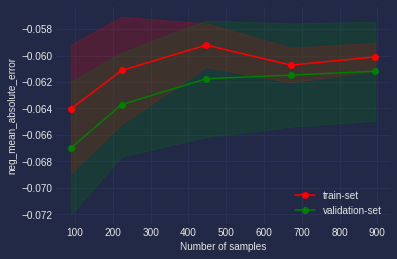

In [ ]:
scoring = 'neg_mean_absolute_error'
plot_learning_curve(linear_regression, X_train_standard, y_train, scoring)

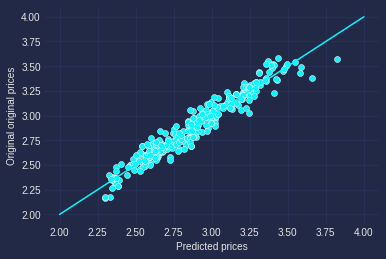

In [ ]:
plot_scatter(linear_regression_predicted, y_test)

## **K-Nearest Neighbors**

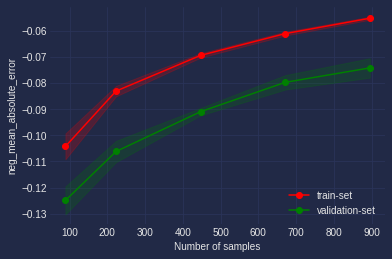

In [ ]:
scoring = 'neg_mean_absolute_error'
plot_learning_curve(KNeighborsRegressor(), X_train_normalized, y_train, scoring)

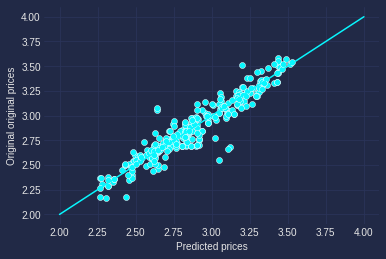

In [ ]:
plot_scatter(knn_predicted, y_test)

## **Voting Regressor**

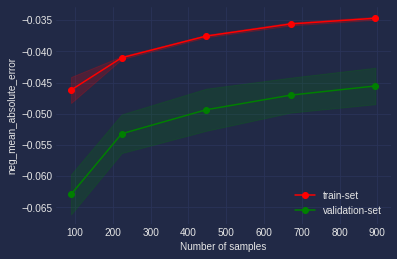

In [ ]:
scoring = 'neg_mean_absolute_error'
plot_learning_curve(voting_regressor, X_train_standard, y_train, scoring)

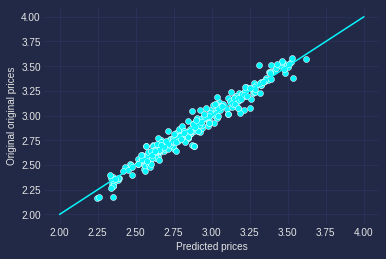

In [ ]:
plot_scatter(voting_regressor_predicted, y_test)

## **Random Forest**

In [ ]:
param_grid = [
    {'max_depth': np.arange(4, 20, 2),
     'n_estimators': np.arange(100, 600, 100),
     'max_leaf_nodes': np.arange(10, 30, 2),
     'min_samples_split': np.arange(5, 20, 5),
     'max_samples': np.arange(200, 1000, 200)}
]
# reg = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, verbose = 3, cv = 4, n_jobs = -1)
# reg.fit(X_train_standard, y_train)

In [ ]:
# print("Лучшие настройки: ",reg.best_params_)
# print("accuracy :",reg.best_score_)

In [ ]:
random_forest = RandomForestRegressor(n_estimators = 300, criterion = 'absolute_error', max_depth = 7, max_leaf_nodes = 16, min_samples_split = 30)

random_forest_model, random_forest_rmse, random_forest_mae, random_forest_predicted = model_build(random_forest, 
                                                                                                  X_train_standard, y_train, 
                                                                                                  X_test_standard, y_test)
print(random_forest_rmse, random_forest_mae)

0.08109941512125711 0.06003635061389601


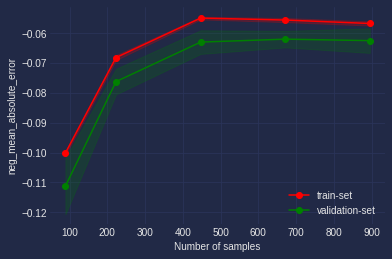

In [ ]:
scoring = 'neg_mean_absolute_error'
plot_learning_curve(random_forest, X_train_standard, y_train, scoring)

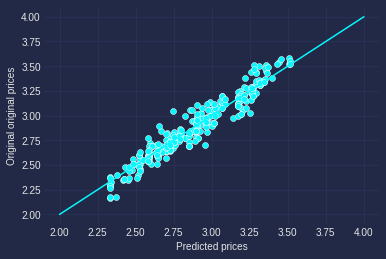

In [ ]:
plot_scatter(random_forest_predicted, y_test)

## **Bagging Regressor with knn**

0.07495497968560369


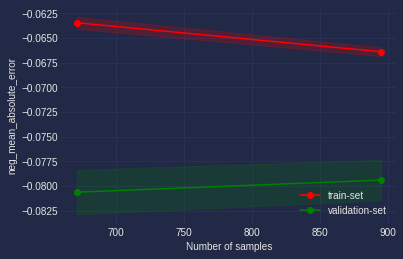

In [ ]:
bagging_knn = BaggingRegressor(KNeighborsRegressor(), n_estimators = 200, max_samples = 600, bootstrap = True, oob_score = True)
bagging_knn_model = bagging_knn.fit(X_train_normalized, y_train)
bagging_knn_predict = bagging_knn_model.predict(X_test_normalized)
print(mean_absolute_error(y_test, bagging_knn_predict))

scoring = 'neg_mean_absolute_error'
plot_learning_curve(bagging_knn, X_train_normalized, y_train, scoring)

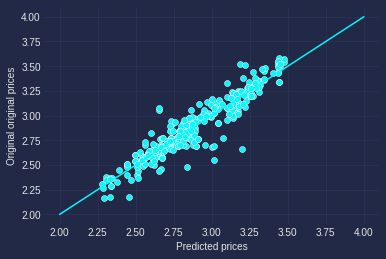

In [ ]:
plot_scatter(bagging_knn_predict, y_test)

## **XGBoost**

0.04255586907884522


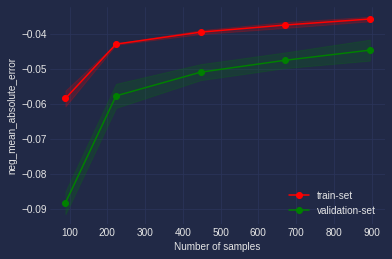

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

xgb_regression = XGBRegressor(objective ='reg:squarederror', n_estimators=200, max_depth = 6, 
                              eta=0.02, subsample=0.7, colsample_bytree=0.65, cv = cv, 
                              reg_alpha = 0.4, reg_lambda = 8, min_child_weight = 10)
                            #   grow_policy = 'lossguide', max_leaves = 12)
# xgb_regression = XGBRegressor(objective ='reg:squarederror')

xgb_regression_model = xgb_regression.fit(X_train_standard, y_train)
xgb_regression_predict = xgb_regression_model.predict(X_test_standard)
print(mean_absolute_error(y_test, xgb_regression_predict))

scoring = 'neg_mean_absolute_error'
plot_learning_curve(xgb_regression, X_train_standard, y_train, scoring)

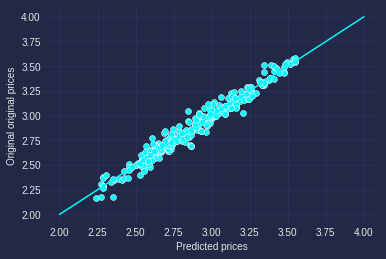

In [ ]:
plot_scatter(xgb_regression_predict, y_test)

## **VotingRegressor of XGBoost and RandomForest**

0.06467339987618224 0.04740908915146845


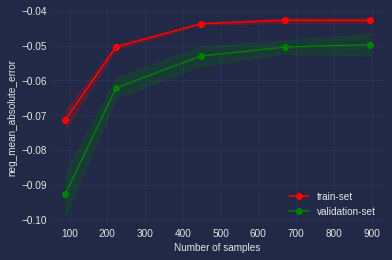

In [ ]:
voting_regressor = VotingRegressor([
                                   ('xgboost', xgb_regression),
                                   ('random_forest', random_forest)
])
voting_regressor_model, voting_regressor_rmse, voting_regressor_mae, voting_regressor_predicted = model_build(voting_regressor, 
                                                                                                              X_train_standard, y_train, 
                                                                                                              X_test_standard, y_test)
print(voting_regressor_rmse, voting_regressor_mae)

scoring = 'neg_mean_absolute_error'
plot_learning_curve(voting_regressor, X_train_standard, y_train, scoring)

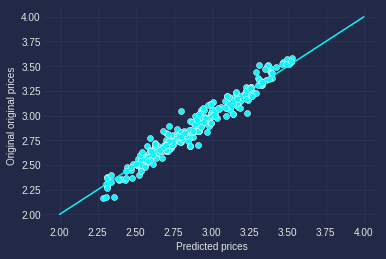

In [ ]:
plot_scatter(voting_regressor_predicted, y_test)

Here I have two kinds of good models. One is based on Extreem Gradient Boosting on the Desicion Trees. The second one is a voting model of XGBoost and Random Forest. For predictions I will use the first model 

## **Validation test**

In [ ]:
xgb_regression_val_predict = xgb_regression_model.predict(X_val_standard)
print(mean_absolute_error(y_val, xgb_regression_val_predict))

0.05407522801165994


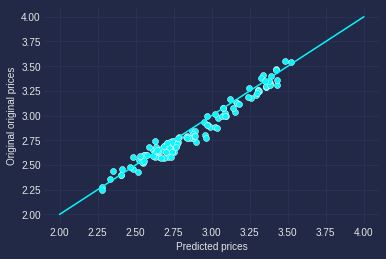

In [ ]:
plot_scatter(xgb_regression_val_predict, y_val)

In [ ]:
print(y_val.mean(), y_val.mad())
print(xgb_regression_val_predict.mean(), pd.Series(xgb_regression_val_predict).mad())

2.8489846762378974 0.26095383988103255
2.881313 0.27046239376068115


In [ ]:
xgb_regression_val_predict_true = 10 ** xgb_regression_val_predict # np.exp(xgb_regression_val_predict)
y_val_true = 10 ** y_val # np.exp(y_val)

123.55121911621094

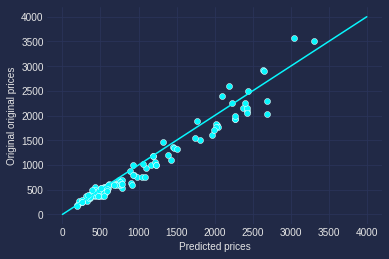

In [ ]:
sns.scatterplot(x = xgb_regression_val_predict_true, y = y_val_true)
sns.lineplot(x = np.arange(0, 5000, 1000), y = np.arange(0, 5000, 1000))
plt.xlabel('Predicted prices')
plt.ylabel('Original original prices')
mean_absolute_error(y_val_true, xgb_regression_val_predict_true)

So, the mean absolute error is 123.5 while mean is 924. It means that accuracy is about 86.64 percent. A good result.

In [ ]:
print(y_val_true.mean(), y_val_true.mad())
print(xgb_regression_val_predict_true.mean(), pd.Series(xgb_regression_val_predict_true).mad())

924.728 596.3507840000004
997.18555 629.9671630859375


$R^2$-score is 0.94 

In [ ]:
r2_score(y_val_true, xgb_regression_val_predict_true)

0.9447430324727123

But still some predicted values a too different from the real. Sometimes it's about half as much as needed

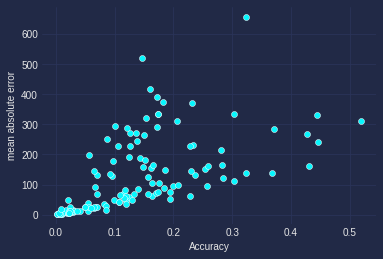

In [ ]:
difference = pd.DataFrame({'mean absolute error': abs(list(y_val_true) - xgb_regression_val_predict_true), 
                           'Accuracy': abs(list(y_val_true)- xgb_regression_val_predict_true) / list(y_val_true)
                           })
sns.scatterplot(data = difference, x = 'Accuracy', y = 'mean absolute error')

Also the model makes more bigger predictions than smaller ones. For my opinion it's so because some important values are not included in the dataset

Text(0, 0.5, 'Difference between original and predicted values')

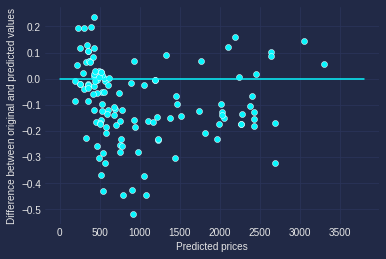

In [ ]:
sns.scatterplot(x = xgb_regression_val_predict_true, y = (list(y_val_true) - xgb_regression_val_predict_true) / list(y_val_true))
sns.lineplot(x = np.arange(0, 4000, 200), y = 0)
plt.xlabel('Predicted prices')
plt.ylabel('Difference between original and predicted values')

# **VIII. Solution**

As a result of a project we can define what are the most important variables for smartphone's prices predictions. Still, for more expensive smartphones we need to find other important vaariables. For example, water resistance.

Also there has been built a predictive model based on a Ml-algorithm "Extreem Gradient Boosting on Desicion Trees", that makes good predictions and can be used in production